In [2]:
import numpy as np
import matplotlib.pyplot as plt
from Corrfunc.theory.DD import DD
from sklearn.neighbors import KernelDensity
from scipy.stats import norm
import scipy.optimize as spo

DATA_DIRECTORY = "/home/vibin/MyFolder/WorkDesk/DP2/PhdProjects/Complicor/Data/"

def pow_func(r, A, alpha):
    return A * np.power(r, -alpha)

font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 14}

import matplotlib
matplotlib.rc('font', **font)

408.5


[Warning] The CPU supports AVX2 but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports AVX but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports SSE4.2 but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports SSE4.1 but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports SSSE3 but the compiler does not.  Can you try another compiler?
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


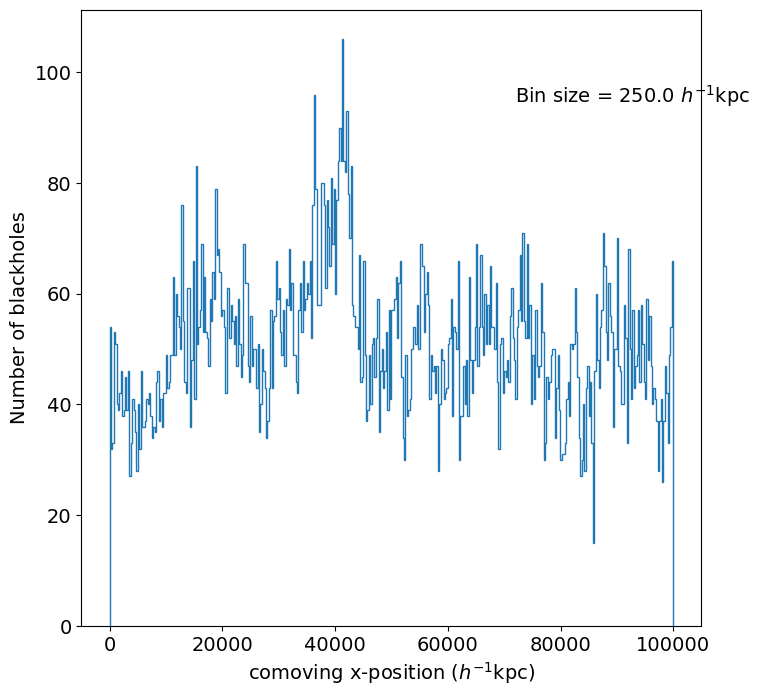

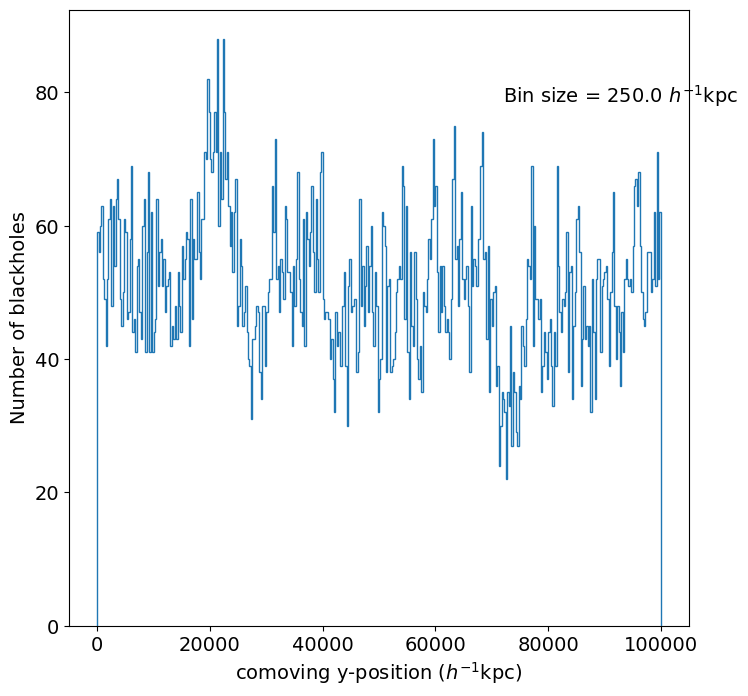

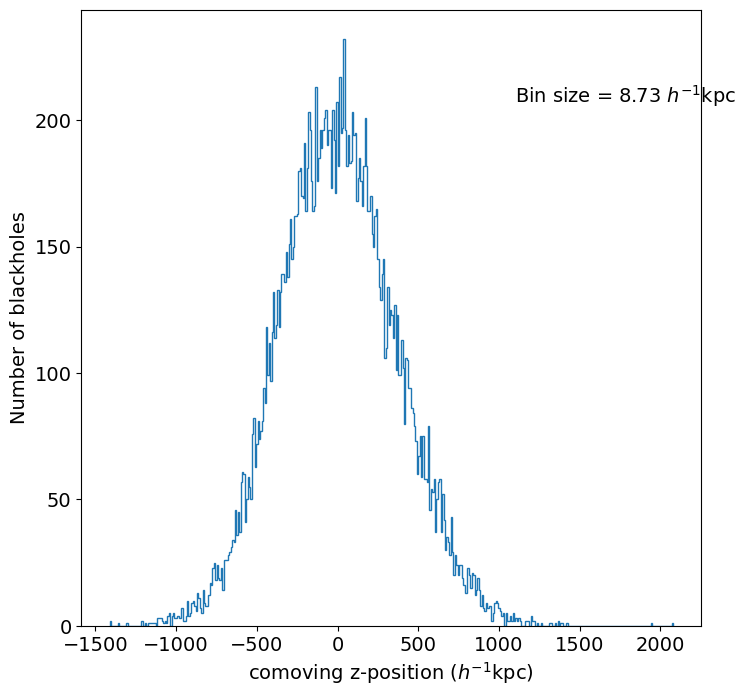

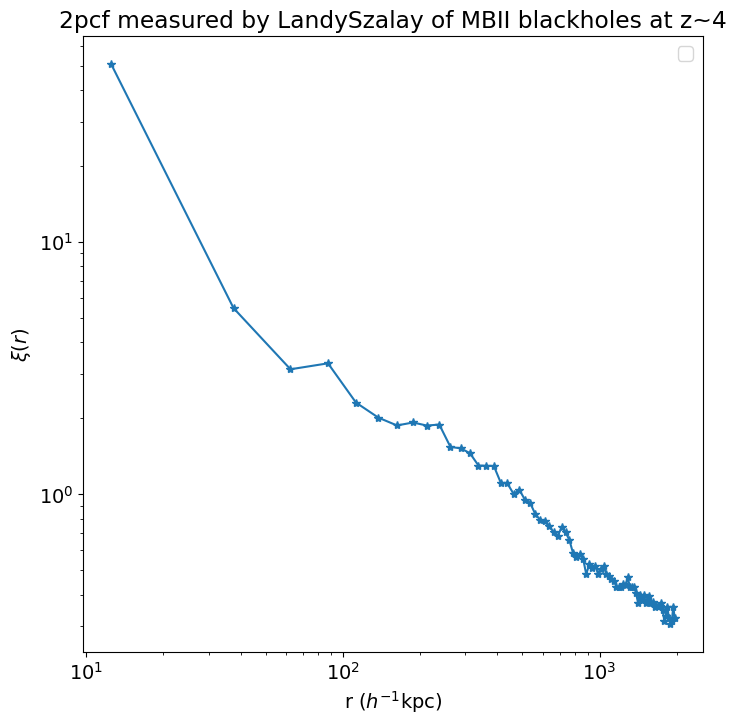

In [2]:
mult = 50 ## Number of random points used as a multiple of number of data points
z_bin_size = 5   ## Bin size used to produce a new z distribution of the random numbers
bin_size = 25  ## Bin size used for correlation function measurement


MBII_z4_filename = "bhprops_034.txt"
MBII_z4 = np.loadtxt(DATA_DIRECTORY + MBII_z4_filename)

bh_pos_x = np.copy(MBII_z4[:, 2])
bh_pos_y = np.copy(MBII_z4[:, 3])
bh_pos_z = np.copy(MBII_z4[:, 4])

min_x = 0
max_x = 100000
min_y = 0
max_y = 100000

n_D = len(bh_pos_x)
n_rand = mult * n_D
rand_x = np.random.uniform(min_x, max_x, n_rand)
rand_y = np.random.uniform(min_y, max_y, n_rand)

#-------------------------------------------------------------------------------------------
#Drawing random numbers for z from smoothed distribution of the data z vals

z_bin = np.arange(np.min(bh_pos_z), np.max(bh_pos_z), z_bin_size)[:,np.newaxis]
z_bin_mid = (z_bin + z_bin_size/2)[:-1]
kde = KernelDensity(kernel="gaussian", bandwidth=50).fit(bh_pos_z[:,np.newaxis])
log_dens = kde.score_samples(z_bin_mid)
pdf = np.exp(log_dens)
# ax.fill(pos_z[:, 0], pdf, fc="#AAAAFF")
cdf = np.cumsum(pdf)
cdf = cdf / np.max(cdf)
cdf = np.insert(cdf, 0, 0)

z_bin = z_bin.flatten()
z_bin_mid = z_bin_mid.flatten()

uni_val = np.random.rand(n_rand)
bin_indices = np.searchsorted(cdf, uni_val)
bin_edges = z_bin[bin_indices - 1]
bin_diff = z_bin[bin_indices] - z_bin[bin_indices-1]
bin_weights = (uni_val - cdf[bin_indices-1]) / (cdf[bin_indices] - cdf[bin_indices-1])
rand_z = bin_edges + bin_weights * bin_diff

#-------------------------------------------------------------------------------------------

print(len(bh_pos_x)/50)

n_bins = 400
fig, ax = plt.subplots(figsize = (8,8))
hist_data = plt.hist(bh_pos_x, bins=n_bins, histtype='step')[0];
ax.set_xlabel(r'comoving x-position ($h^{-1}$kpc)')
ax.set_ylabel(r'Number of blackholes')
ax.text(0.70, 0.85, r'Bin size = {} $h^{{-1}}$kpc'.format(np.round((max_x - min_x)/n_bins, 2)), transform = ax.transAxes)

fig2, ax2 = plt.subplots(figsize = (8,8))
hist_data = plt.hist(bh_pos_y, bins=n_bins, histtype='step')[0];
ax2.set_xlabel(r'comoving y-position ($h^{-1}$kpc)')
ax2.set_ylabel(r'Number of blackholes')
ax2.text(0.70, 0.85, r'Bin size = {} $h^{{-1}}$kpc'.format(np.round((max_y - min_y)/n_bins, 2)), transform = ax2.transAxes)

fig3, ax3 = plt.subplots(figsize = (8,8))
hist_data = plt.hist(bh_pos_z, bins=n_bins, histtype='step')[0];
ax3.set_xlabel(r'comoving z-position ($h^{-1}$kpc)')
ax3.set_ylabel(r'Number of blackholes')
ax3.text(0.70, 0.85, r'Bin size = {} $h^{{-1}}$kpc'.format(np.round((np.max(bh_pos_z) - np.min(bh_pos_z))/n_bins, 2)), transform = ax3.transAxes)

## ---------------------------------------------------------------------------------------------------------------------------------------------------

bins = np.arange(0, 2000, bin_size)
bin_mids = (bins[0:-1] + bins[1:])/2

result_DD = DD(autocorr=1, nthreads=1, binfile=bins, X1 = bh_pos_x, Y1 = bh_pos_y, Z1 = bh_pos_z, periodic=False)
result_RR = DD(autocorr=1, nthreads=1, binfile=bins, X1 = rand_x, Y1 = rand_y, Z1 = rand_z, periodic=False)
result_DR = DD(autocorr=0, nthreads=1, binfile=bins, X1 = bh_pos_x, Y1 = bh_pos_y, Z1 = bh_pos_z, X2 = rand_x, Y2 = rand_y, Z2 = rand_z, periodic=False)

DD_norm = (n_D * (n_D - 1))/2
RR_norm = (n_rand * (n_rand - 1))/2
DR_norm = n_D * n_rand

DD_count = result_DD['npairs']/2
RR_count = result_RR['npairs']/2
DR_count = result_DR['npairs']

LandSzal2pcf = (DD_count/DD_norm - 2 * DR_count/DR_norm + RR_count/RR_norm)/(RR_count/RR_norm)

fig, ax = plt.subplots(figsize = (8,8))
ax.plot(bin_mids, LandSzal2pcf, '-*')
ax.set_xlabel(r'r ($h^{-1}$kpc)')
ax.set_ylabel(r'$\xi(r)$')
ax.set_title("2pcf measured by LandySzalay of MBII blackholes at z~4")
ax.set_xscale('log')
ax.set_yscale('log')

temp_popt, temp_pcov = spo.curve_fit(pow_func, bin_mids, LandSzal2pcf)
_2pcf_fit_alpha = temp_popt[1]
_2pcf_fit_A = temp_popt[0]
# ax.plot(bin_mids, pow_func(bin_mids, _2pcf_fit_A, _2pcf_fit_alpha), label=r"plaw Fit: A = {}, $\alpha = {}$".format(np.round(_2pcf_fit_A, 3), np.round(_2pcf_fit_alpha,3)))
ax.legend()

Text(0.5, 1.0, 'Blackhole distribution projected along z axis. Redshift ~ 4')

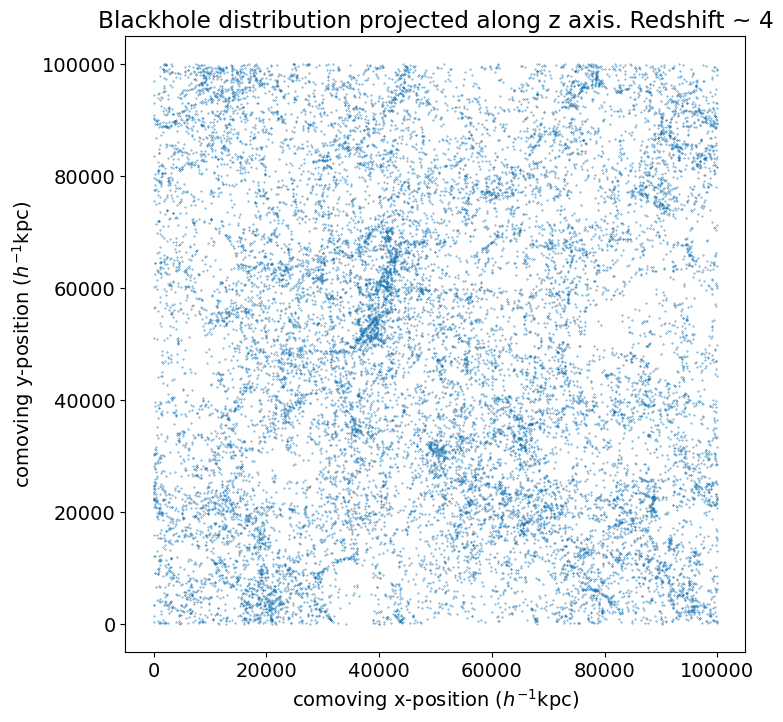

In [3]:
fig, ax = plt.subplots(figsize = (8,8))
ax.scatter(bh_pos_x, bh_pos_y, s=0.1)
ax.set_xlabel(r'comoving x-position ($h^{-1}$kpc)')
ax.set_ylabel(r'comoving y-position ($h^{-1}$kpc)')
ax.set_title('Blackhole distribution projected along z axis. Redshift ~ 4')

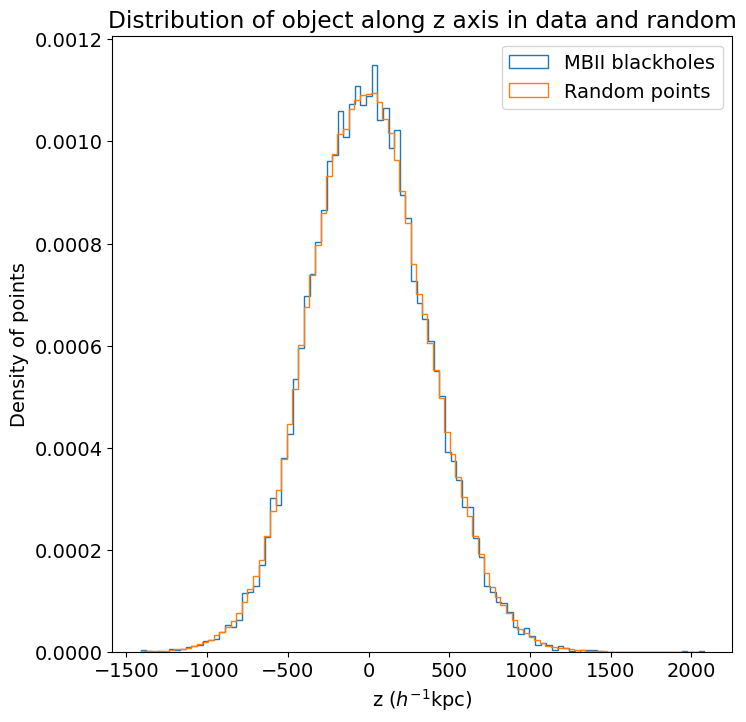

In [3]:
fig, ax = plt.subplots(figsize = (8,8))
ax.hist(bh_pos_z, bins=100, histtype='step', density=True, label="MBII blackholes");
ax.hist(rand_z, bins=100, histtype='step', density=True, label="Random points");
ax.set_xlabel(r"z ($h^{-1}$kpc)")
ax.set_ylabel("Density of points")
ax.set_title("Distribution of object along z axis in data and random")
ax.legend()

[Warning] The CPU supports AVX2 but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports AVX but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports SSE4.2 but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports SSE4.1 but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports SSSE3 but the compiler does not.  Can you try another compiler?


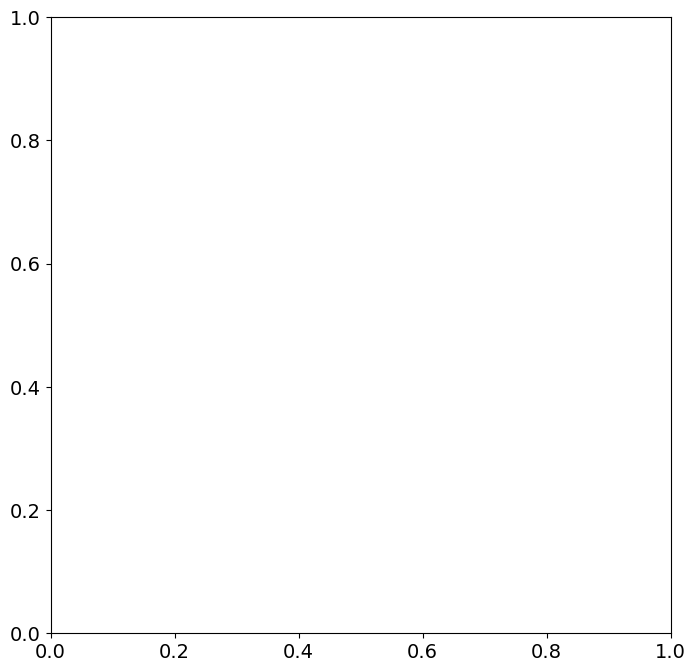

In [4]:
MBII_z4_filename = "bhprops_034.txt"
MBII_z4 = np.loadtxt(DATA_DIRECTORY + MBII_z4_filename)

bh_pos_x = np.copy(MBII_z4[:, 2])
bh_pos_y = np.copy(MBII_z4[:, 3])
bh_pos_z = np.copy(MBII_z4[:, 4])

min_x = 0
max_x = 100000
min_y = 0
max_y = 100000

mult = 50 ## Number of random points used as a multiple of number of data points
z_bin_size = 5   ## Bin size used to produce a new z distribution of the random numbers
bin_size_ar = [50]  ## Bin size used for correlation function measurement

for bin_size in bin_size_ar:

    n_D = len(bh_pos_x)
    n_rand = mult * n_D
    rand_x = np.random.uniform(min_x, max_x, n_rand)
    rand_y = np.random.uniform(min_y, max_y, n_rand)

    #-------------------------------------------------------------------------------------------
    #Drawing random numbers for z from smoothed distribution of the data z vals

    z_bin = np.arange(np.min(bh_pos_z), np.max(bh_pos_z), z_bin_size)[:,np.newaxis]
    z_bin_mid = (z_bin + z_bin_size/2)[:-1]
    kde = KernelDensity(kernel="gaussian", bandwidth=50).fit(bh_pos_z[:,np.newaxis])
    log_dens = kde.score_samples(z_bin_mid)
    pdf = np.exp(log_dens)
    # ax.fill(pos_z[:, 0], pdf, fc="#AAAAFF")
    cdf = np.cumsum(pdf)
    cdf = cdf / np.max(cdf)
    cdf = np.insert(cdf, 0, 0)

    z_bin = z_bin.flatten()
    z_bin_mid = z_bin_mid.flatten()

    uni_val = np.random.rand(n_rand)
    bin_indices = np.searchsorted(cdf, uni_val)
    bin_edges = z_bin[bin_indices - 1]
    bin_diff = z_bin[bin_indices] - z_bin[bin_indices-1]
    bin_weights = (uni_val - cdf[bin_indices-1]) / (cdf[bin_indices] - cdf[bin_indices-1])
    rand_z = bin_edges + bin_weights * bin_diff

    ## ---------------------------------------------------------------------------------------------------------------------------------------------------

    bins = np.arange(0.01, 8000, bin_size)
    bin_mids = (bins[0:-1] + bins[1:])/2

    result_DD = DD(autocorr=1, nthreads=1, binfile=bins, X1 = bh_pos_x, Y1 = bh_pos_y, Z1 = bh_pos_z, periodic=False)
    result_RR = DD(autocorr=1, nthreads=1, binfile=bins, X1 = rand_x, Y1 = rand_y, Z1 = rand_z, periodic=False)
    result_DR = DD(autocorr=0, nthreads=1, binfile=bins, X1 = bh_pos_x, Y1 = bh_pos_y, Z1 = bh_pos_z, X2 = rand_x, Y2 = rand_y, Z2 = rand_z, periodic=False)

    DD_norm = (n_D * (n_D - 1))/2
    RR_norm = (n_rand * (n_rand - 1))/2
    DR_norm = n_D * n_rand

    DD_count = result_DD['npairs']/2
    RR_count = result_RR['npairs']/2
    DR_count = result_DR['npairs']

    LandSzal2pcf = (DD_count/DD_norm - 2 * DR_count/DR_norm + RR_count/RR_norm)/(RR_count/RR_norm)

    pois_err = (1 + LandSzal2pcf)/np.sqrt(np.minimum(DD_count, n_D))

from pandas import DataFrame

df = DataFrame({"r min":bins[0:-1], "r max":bins[1:], "DD count":DD_count, "DR count":DR_count, "RR count": RR_count, "Landy Szalay":LandSzal2pcf, "Pois Error":pois_err})

df.to_excel('MBIIz4.xlsx', sheet_name='sheet1', index=False)

# temp_popt, temp_pcov = spo.curve_fit(pow_func, bin_mids, LandSzal2pcf)
# _2pcf_fit_alpha = temp_popt[1]
# _2pcf_fit_A = temp_popt[0]
# ax.plot(bin_mids, pow_func(bin_mids, _2pcf_fit_A, _2pcf_fit_alpha), label=r"plaw Fit: A = {}, $\alpha = {}$".format(np.round(_2pcf_fit_A, 3), np.round(_2pcf_fit_alpha,3)))


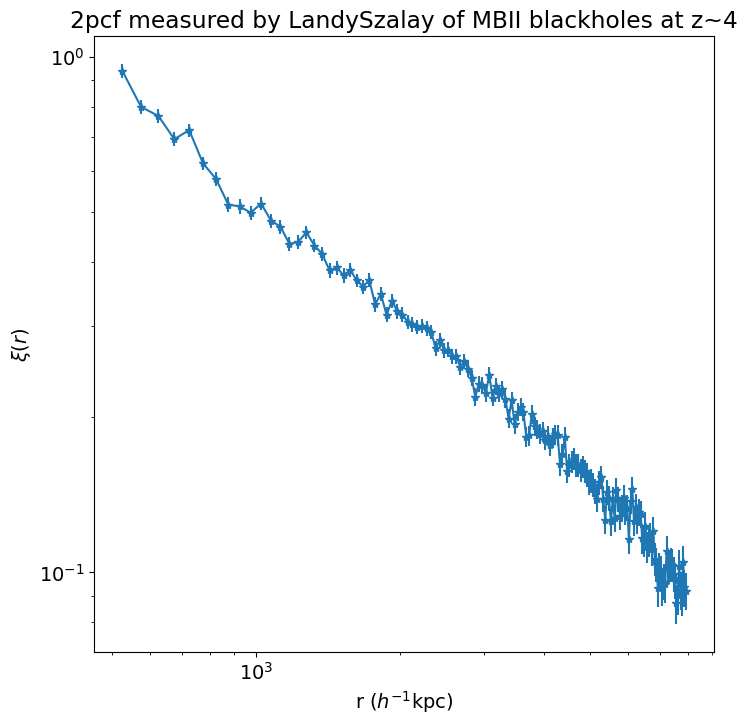

In [3]:
import pandas as pd

temp_z4clust = pd.read_excel('MBIIz4.xlsx', sheet_name='sheet1')
LandSzal2pcf = temp_z4clust['Landy Szalay']
bin_mids = (temp_z4clust['r min'] + temp_z4clust['r max'])/2
pois_err = temp_z4clust['Pois Error']

cutoff = np.argmax(LandSzal2pcf < 1)

fig, ax = plt.subplots(figsize = (8,8))
ax.errorbar(bin_mids[cutoff:], LandSzal2pcf[cutoff:], pois_err[cutoff:], fmt='-*')
ax.set_xlabel(r'r ($h^{-1}$kpc)')
ax.set_ylabel(r'$\xi(r)$')
ax.set_title("2pcf measured by LandySzalay of MBII blackholes at z~4")
ax.set_xscale('log')
ax.set_yscale('log')

In [7]:
def model(theta, s):
    s0, delta = theta
    return np.power(s/s0, -delta)

model_v = np.vectorize(model, excluded=['theta'])

def lnlike(theta, s_mid, xi_s, xi_s_error):
    xi_s_mod = model(theta, s_mid)

    Lnlike = np.sum(np.power((xi_s - xi_s_mod)/(xi_s_error), 2) * (-0.5))
    return Lnlike

def lnprior(theta):
    s0_min, s0_max = 100, 700
    delta_min, delta_max = 0, 5

    s0, delta = theta
    if ((s0_min <= s0 <= s0_max) & (delta_min <= delta <= delta_max)):
        return 0.0
    else:
        return -np.inf

def lnprob(theta, s_mid, xi_s, xi_s_error):
    lp = lnprior(theta)
    if np.isinf(lp):
        return -np.inf
    else:
        return lp + lnlike(theta, s_mid, xi_s, xi_s_error)

(500000, 2)


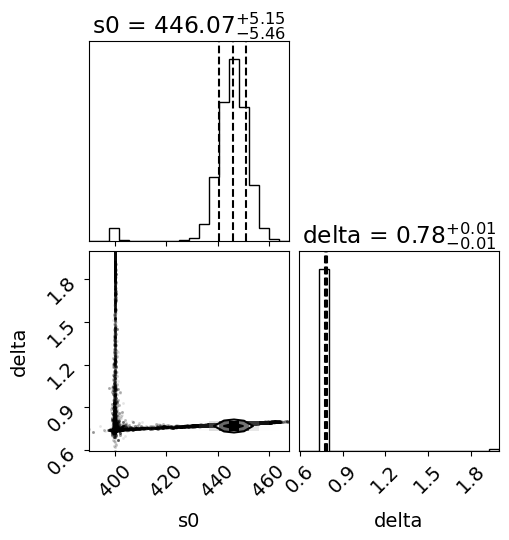

In [9]:
import emcee
import matplotlib as mpl

initial = np.array([400, 2.0])
ndim = len(initial)

nwalkers = 100

data = (bin_mids[cutoff:], LandSzal2pcf[cutoff:], pois_err[cutoff:])

p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)
sampler.run_mcmc(p0, 1000);
sampler.reset()

sampler.run_mcmc(p0, 5000);

samples = sampler.flatchain
print(samples.shape)

import corner
mpl.rcParams['font.size'] = 14
labels = ['s0', 'delta']
fig = corner.corner(samples, show_titles=True, labels=labels, plot_datapoints=True, quantiles=[0.16, 0.5, 0.84])
plt.show()

In [29]:
samples.shape

(500000, 2)

/tmp/ipykernel_4872/307647676.py:2: RuntimeWarning: divide by zero encountered in power
  temp_xi = np.power(temp_s/446.07, -0.78)


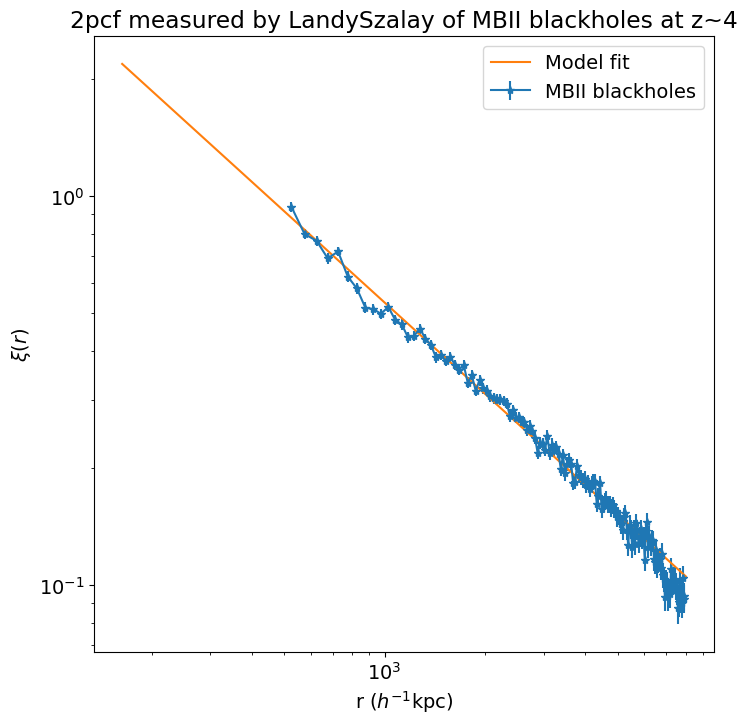

In [12]:
temp_s = np.linspace(0, 8000)
temp_xi = np.power(temp_s/446.07, -0.78)

fig, ax = plt.subplots(figsize = (8,8))
ax.errorbar(bin_mids[cutoff:], LandSzal2pcf[cutoff:], pois_err[cutoff:], fmt='-*', label="MBII blackholes")
ax.plot(temp_s, temp_xi, label="Model fit")
ax.set_xlabel(r'r ($h^{-1}$kpc)')
ax.set_ylabel(r'$\xi(r)$')
ax.set_title("2pcf measured by LandySzalay of MBII blackholes at z~4")
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

### Doing MCMC for all the redshifts 

#### z4

In [ ]:
MBII_z4_filename = "bhprops_034.txt"
MBII_z4 = np.loadtxt(DATA_DIRECTORY + MBII_z4_filename)

bh_pos_x = np.copy(MBII_z4[:, 2])
bh_pos_y = np.copy(MBII_z4[:, 3])
bh_pos_z = np.copy(MBII_z4[:, 4])

min_x = 0
max_x = 100000
min_y = 0
max_y = 100000

mult = 50 ## Number of random points used as a multiple of number of data points
z_bin_size = 5   ## Bin size used to produce a new z distribution of the random numbers
bin_size_ar = [50]  ## Bin size used for correlation function measurement

for bin_size in bin_size_ar:

    n_D = len(bh_pos_x)
    n_rand = mult * n_D
    rand_x = np.random.uniform(min_x, max_x, n_rand)
    rand_y = np.random.uniform(min_y, max_y, n_rand)

    #-------------------------------------------------------------------------------------------
    #Drawing random numbers for z from smoothed distribution of the data z vals

    z_bin = np.arange(np.min(bh_pos_z), np.max(bh_pos_z), z_bin_size)[:,np.newaxis]
    z_bin_mid = (z_bin + z_bin_size/2)[:-1]
    kde = KernelDensity(kernel="gaussian", bandwidth=50).fit(bh_pos_z[:,np.newaxis])
    log_dens = kde.score_samples(z_bin_mid)
    pdf = np.exp(log_dens)
    # ax.fill(pos_z[:, 0], pdf, fc="#AAAAFF")
    cdf = np.cumsum(pdf)
    cdf = cdf / np.max(cdf)
    cdf = np.insert(cdf, 0, 0)

    z_bin = z_bin.flatten()
    z_bin_mid = z_bin_mid.flatten()

    uni_val = np.random.rand(n_rand)
    bin_indices = np.searchsorted(cdf, uni_val)
    bin_edges = z_bin[bin_indices - 1]
    bin_diff = z_bin[bin_indices] - z_bin[bin_indices-1]
    bin_weights = (uni_val - cdf[bin_indices-1]) / (cdf[bin_indices] - cdf[bin_indices-1])
    rand_z = bin_edges + bin_weights * bin_diff

    ## ---------------------------------------------------------------------------------------------------------------------------------------------------

    bins = np.arange(0.01, 8000, bin_size)
    bin_mids = (bins[0:-1] + bins[1:])/2

    result_DD = DD(autocorr=1, nthreads=1, binfile=bins, X1 = bh_pos_x, Y1 = bh_pos_y, Z1 = bh_pos_z, periodic=False)
    result_RR = DD(autocorr=1, nthreads=1, binfile=bins, X1 = rand_x, Y1 = rand_y, Z1 = rand_z, periodic=False)
    result_DR = DD(autocorr=0, nthreads=1, binfile=bins, X1 = bh_pos_x, Y1 = bh_pos_y, Z1 = bh_pos_z, X2 = rand_x, Y2 = rand_y, Z2 = rand_z, periodic=False)

    DD_norm = (n_D * (n_D - 1))/2
    RR_norm = (n_rand * (n_rand - 1))/2
    DR_norm = n_D * n_rand

    DD_count = result_DD['npairs']/2
    RR_count = result_RR['npairs']/2
    DR_count = result_DR['npairs']

    LandSzal2pcf = (DD_count/DD_norm - 2 * DR_count/DR_norm + RR_count/RR_norm)/(RR_count/RR_norm)

    pois_err = (1 + LandSzal2pcf)/np.sqrt(np.minimum(DD_count, n_D))

from pandas import DataFrame

df = DataFrame({"r min":bins[0:-1], "r max":bins[1:], "DD count":DD_count, "DR count":DR_count, "RR count": RR_count, "Landy Szalay":LandSzal2pcf, "Pois Error":pois_err})

df.to_excel('MBIIz4.xlsx', sheet_name='sheet1', index=False)

# temp_popt, temp_pcov = spo.curve_fit(pow_func, bin_mids, LandSzal2pcf)
# _2pcf_fit_alpha = temp_popt[1]
# _2pcf_fit_A = temp_popt[0]
# ax.plot(bin_mids, pow_func(bin_mids, _2pcf_fit_A, _2pcf_fit_alpha), label=r"plaw Fit: A = {}, $\alpha = {}$".format(np.round(_2pcf_fit_A, 3), np.round(_2pcf_fit_alpha,3)))

import pandas as pd

temp_z4clust = pd.read_excel('MBIIz4.xlsx', sheet_name='sheet1')
LandSzal2pcf = temp_z4clust['Landy Szalay']
bin_mids = (temp_z4clust['r min'] + temp_z4clust['r max'])/2
pois_err = temp_z4clust['Pois Error']

cutoff = np.argmax(LandSzal2pcf < 1)

fig, ax = plt.subplots(figsize = (8,8))
ax.errorbar(bin_mids[cutoff:], LandSzal2pcf[cutoff:], pois_err[cutoff:], fmt='-*')
ax.set_xlabel(r'r ($h^{-1}$kpc)')
ax.set_ylabel(r'$\xi(r)$')
ax.set_title("2pcf measured by LandySzalay of MBII blackholes at z~4")
ax.set_xscale('log')
ax.set_yscale('log')
def model(theta, s):
    s0, delta = theta
    return np.power(s/s0, -delta)

model_v = np.vectorize(model, excluded=['theta'])

def lnlike(theta, s_mid, xi_s, xi_s_error):
    xi_s_mod = model(theta, s_mid)

    Lnlike = np.sum(np.power((xi_s - xi_s_mod)/(xi_s_error), 2) * (-0.5))
    return Lnlike

def lnprior(theta):
    s0_min, s0_max = 100, 700
    delta_min, delta_max = 0, 5

    s0, delta = theta
    if ((s0_min <= s0 <= s0_max) & (delta_min <= delta <= delta_max)):
        return 0.0
    else:
        return -np.inf

def lnprob(theta, s_mid, xi_s, xi_s_error):
    lp = lnprior(theta)
    if np.isinf(lp):
        return -np.inf
    else:
        return lp + lnlike(theta, s_mid, xi_s, xi_s_error)
import emcee
import matplotlib as mpl

initial = np.array([400, 2.0])
ndim = len(initial)

nwalkers = 100

data = (bin_mids[cutoff:], LandSzal2pcf[cutoff:], pois_err[cutoff:])

p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)
sampler.run_mcmc(p0, 1000);
sampler.reset()

sampler.run_mcmc(p0, 5000);

samples = sampler.flatchain
print(samples.shape)

import corner
mpl.rcParams['font.size'] = 14
labels = ['s0', 'delta']
fig = corner.corner(samples, show_titles=True, labels=labels, plot_datapoints=True, quantiles=[0.16, 0.5, 0.84])
plt.show()
temp_s = np.linspace(0, 8000)
temp_xi = np.power(temp_s/446.07, -0.78)

fig, ax = plt.subplots(figsize = (8,8))
ax.errorbar(bin_mids[cutoff:], LandSzal2pcf[cutoff:], pois_err[cutoff:], fmt='-*', label="MBII blackholes")
ax.plot(temp_s, temp_xi, label="Model fit")
ax.set_xlabel(r'r ($h^{-1}$kpc)')
ax.set_ylabel(r'$\xi(r)$')
ax.set_title("2pcf measured by LandySzalay of MBII blackholes at z~4")
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

#### z5

In [2]:
MBII_z4_filename = "bhprops_024.txt"
MBII_z4 = np.loadtxt(DATA_DIRECTORY + MBII_z4_filename)

bh_pos_x = np.copy(MBII_z4[:, 2])
bh_pos_y = np.copy(MBII_z4[:, 3])
bh_pos_z = np.copy(MBII_z4[:, 4])

min_x = 0
max_x = 100000
min_y = 0
max_y = 100000

mult = 50 ## Number of random points used as a multiple of number of data points
z_bin_size = 5   ## Bin size used to produce a new z distribution of the random numbers
bin_size_ar = [50]  ## Bin size used for correlation function measurement

for bin_size in bin_size_ar:

    n_D = len(bh_pos_x)
    n_rand = mult * n_D
    rand_x = np.random.uniform(min_x, max_x, n_rand)
    rand_y = np.random.uniform(min_y, max_y, n_rand)

    #-------------------------------------------------------------------------------------------
    #Drawing random numbers for z from smoothed distribution of the data z vals

    z_bin = np.arange(np.min(bh_pos_z), np.max(bh_pos_z), z_bin_size)[:,np.newaxis]
    z_bin_mid = (z_bin + z_bin_size/2)[:-1]
    kde = KernelDensity(kernel="gaussian", bandwidth=50).fit(bh_pos_z[:,np.newaxis])
    log_dens = kde.score_samples(z_bin_mid)
    pdf = np.exp(log_dens)
    # ax.fill(pos_z[:, 0], pdf, fc="#AAAAFF")
    cdf = np.cumsum(pdf)
    cdf = cdf / np.max(cdf)
    cdf = np.insert(cdf, 0, 0)

    z_bin = z_bin.flatten()
    z_bin_mid = z_bin_mid.flatten()

    uni_val = np.random.rand(n_rand)
    bin_indices = np.searchsorted(cdf, uni_val)
    bin_edges = z_bin[bin_indices - 1]
    bin_diff = z_bin[bin_indices] - z_bin[bin_indices-1]
    bin_weights = (uni_val - cdf[bin_indices-1]) / (cdf[bin_indices] - cdf[bin_indices-1])
    rand_z = bin_edges + bin_weights * bin_diff

    ## ---------------------------------------------------------------------------------------------------------------------------------------------------

    bins = np.arange(0.01, 8000, bin_size)
    bin_mids = (bins[0:-1] + bins[1:])/2

    result_DD = DD(autocorr=1, nthreads=1, binfile=bins, X1 = bh_pos_x, Y1 = bh_pos_y, Z1 = bh_pos_z, periodic=False)
    result_RR = DD(autocorr=1, nthreads=1, binfile=bins, X1 = rand_x, Y1 = rand_y, Z1 = rand_z, periodic=False)
    result_DR = DD(autocorr=0, nthreads=1, binfile=bins, X1 = bh_pos_x, Y1 = bh_pos_y, Z1 = bh_pos_z, X2 = rand_x, Y2 = rand_y, Z2 = rand_z, periodic=False)

    DD_norm = (n_D * (n_D - 1))/2
    RR_norm = (n_rand * (n_rand - 1))/2
    DR_norm = n_D * n_rand

    DD_count = result_DD['npairs']/2
    RR_count = result_RR['npairs']/2
    DR_count = result_DR['npairs']

    LandSzal2pcf = (DD_count/DD_norm - 2 * DR_count/DR_norm + RR_count/RR_norm)/(RR_count/RR_norm)

    pois_err = (1 + LandSzal2pcf)/np.sqrt(np.minimum(DD_count, n_D))

from pandas import DataFrame

df = DataFrame({"r min":bins[0:-1], "r max":bins[1:], "DD count":DD_count, "DR count":DR_count, "RR count": RR_count, "Landy Szalay":LandSzal2pcf, "Pois Error":pois_err})

df.to_excel('MBIIz8.xlsx', sheet_name='sheet1', index=False)

# temp_popt, temp_pcov = spo.curve_fit(pow_func, bin_mids, LandSzal2pcf)
# _2pcf_fit_alpha = temp_popt[1]
# _2pcf_fit_A = temp_popt[0]
# ax.plot(bin_mids, pow_func(bin_mids, _2pcf_fit_A, _2pcf_fit_alpha), label=r"plaw Fit: A = {}, $\alpha = {}$".format(np.round(_2pcf_fit_A, 3), np.round(_2pcf_fit_alpha,3)))


[Warning] The CPU supports AVX2 but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports AVX but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports SSE4.2 but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports SSE4.1 but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports SSSE3 but the compiler does not.  Can you try another compiler?
/tmp/ipykernel_8545/3660898487.py:66: RuntimeWarning: divide by zero encountered in divide
  pois_err = (1 + LandSzal2pcf)/np.sqrt(np.minimum(DD_count, n_D))


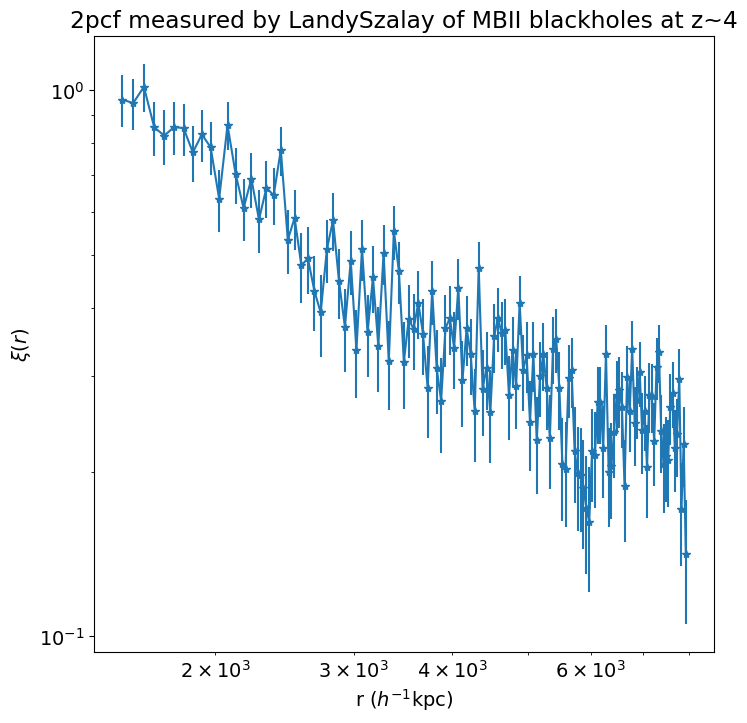

In [4]:
import pandas as pd

temp_z4clust = pd.read_excel('MBIIz6.xlsx', sheet_name='sheet1')
LandSzal2pcf = temp_z4clust['Landy Szalay']
bin_mids = (temp_z4clust['r min'] + temp_z4clust['r max'])/2
pois_err = temp_z4clust['Pois Error']

cutoff = np.argmax(LandSzal2pcf < 1)

fig, ax = plt.subplots(figsize = (8,8))
ax.errorbar(bin_mids[cutoff:], LandSzal2pcf[cutoff:], pois_err[cutoff:], fmt='-*')
ax.set_xlabel(r'r ($h^{-1}$kpc)')
ax.set_ylabel(r'$\xi(r)$')
ax.set_title("2pcf measured by LandySzalay of MBII blackholes at z~4")
ax.set_xscale('log')
ax.set_yscale('log')

In [17]:
def model(theta, s):
    s0, delta = theta
    return np.power(s/s0, -delta)

model_v = np.vectorize(model, excluded=['theta'])

def lnlike(theta, s_mid, xi_s, xi_s_error):
    xi_s_mod = model(theta, s_mid)

    Lnlike = np.sum(np.power((xi_s - xi_s_mod)/(xi_s_error), 2) * (-0.5))
    return Lnlike

def lnprior(theta):
    s0_min, s0_max = 1000, 1500
    delta_min, delta_max = 0, 2

    s0, delta = theta
    if ((s0_min <= s0 <= s0_max) & (delta_min <= delta <= delta_max)):
        return 0.0
    else:
        return -np.inf

def lnprob(theta, s_mid, xi_s, xi_s_error):
    lp = lnprior(theta)
    if np.isinf(lp):
        return -np.inf
    else:
        return lp + lnlike(theta, s_mid, xi_s, xi_s_error)

(500000, 2)


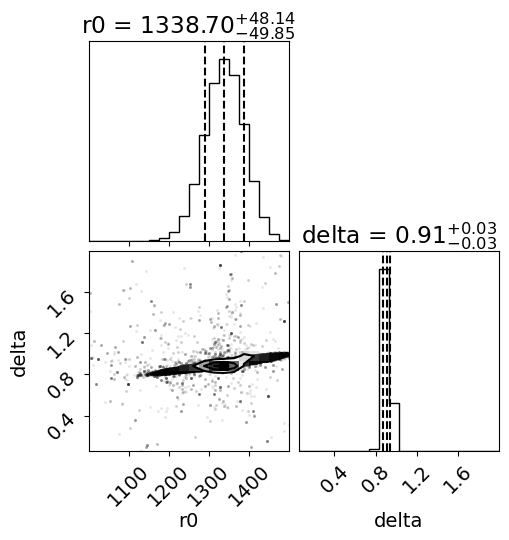

In [18]:
import emcee
import matplotlib as mpl

initial = np.array([1200, 1.0])
ndim = len(initial)

nwalkers = 100

data = (bin_mids[cutoff:], LandSzal2pcf[cutoff:], pois_err[cutoff:])

p0 = np.random.uniform(low = np.array([1000, 0]), high = np.array([1500, 2]), size = (nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)
sampler.run_mcmc(p0, 1000);
sampler.reset()

sampler.run_mcmc(p0, 5000);

samples = sampler.flatchain
print(samples.shape)

import corner
mpl.rcParams['font.size'] = 14
labels = ['r0', 'delta']
fig = corner.corner(samples, show_titles=True, labels=labels, plot_datapoints=True, quantiles=[0.16, 0.5, 0.84])
plt.show()

In [19]:
print("Mean acceptance rate is: {0:1.2f}".format(np.mean(sampler.acceptance_fraction)))

Mean acceptance rate is: 0.71


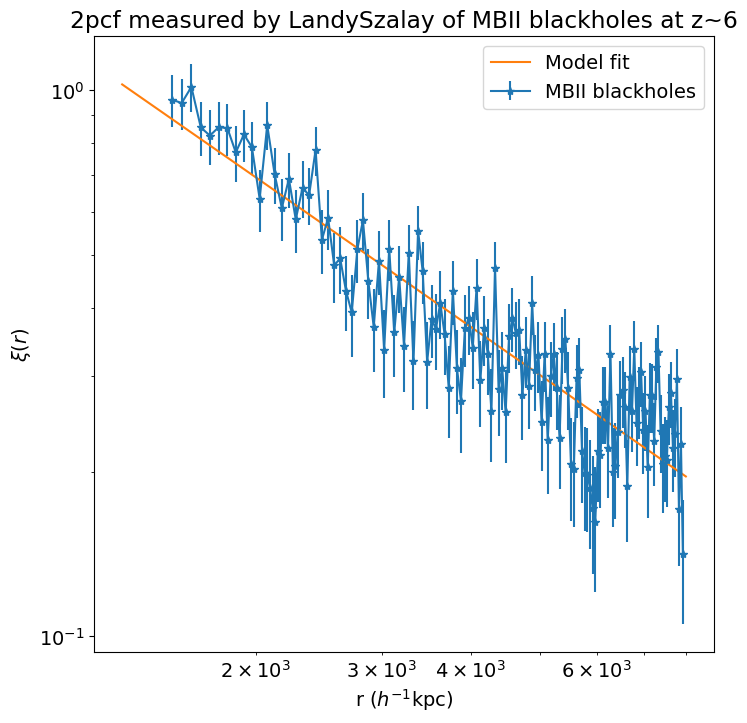

In [49]:
temp_s = np.linspace(1300, 8000)
temp_xi = np.power(temp_s/1337.06, -0.91)

fig, ax = plt.subplots(figsize = (8,8))
ax.errorbar(bin_mids[cutoff:], LandSzal2pcf[cutoff:], pois_err[cutoff:], fmt='-*', label="MBII blackholes")
ax.plot(temp_s, temp_xi, label="Model fit")
ax.set_xlabel(r'r ($h^{-1}$kpc)')
ax.set_ylabel(r'$\xi(r)$')
ax.set_title("2pcf measured by LandySzalay of MBII blackholes at z~6")
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_xlim(1000,8000)
ax.legend()

#### Trying to make the fig.25 of Khandai et al. 2015

In [45]:
MBII_fig25_filename = "Khandai_fig25_data.csv"
MBII_fig25 = np.loadtxt(DATA_DIRECTORY + MBII_fig25_filename, skiprows=1, delimiter=',')

# column 1 = redshift z
# column 2 = clustering length r_0
# column 3 = upper error bar of r_0
# column 4 = lower error bar of r_0
# column 5 = difference of column 4 from column 3

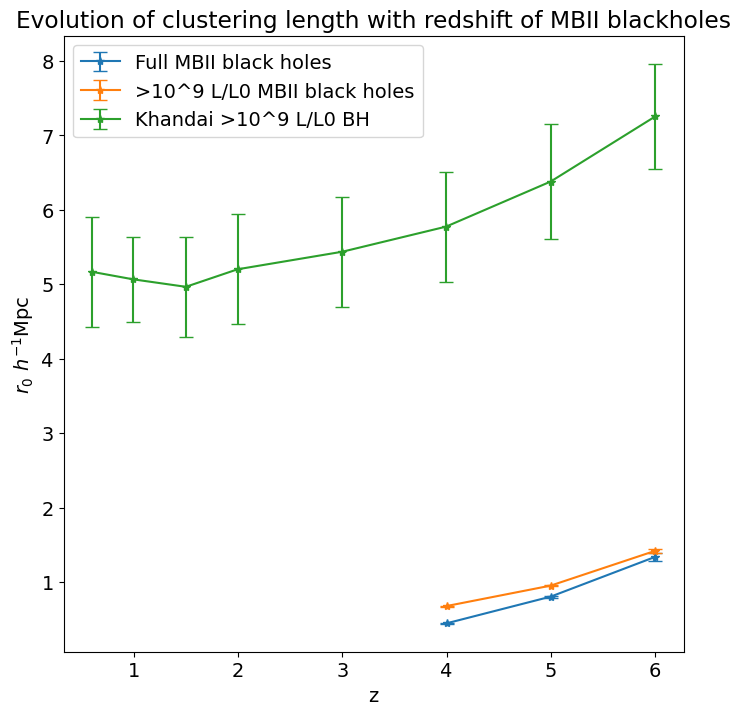

In [48]:
fig, ax = plt.subplots(figsize = (8,8))
ax.errorbar([4,5,6], [.44604, .80475, 1.33706], yerr=[[.00515, .01232, .04845], [.00545, .01287, .05290]], fmt='*-', capsize=5, label="Full MBII black holes")
ax.errorbar([4,5,6], [.67816, .95277, 1.41845], yerr=[[.00612, .01120, .02546], [.00624, .01158, .02558]], fmt='*-', capsize=5, label=">10^9 L/L0 MBII black holes")
ax.errorbar(MBII_fig25[:,0], MBII_fig25[:,1], yerr=MBII_fig25[:,4], fmt='*-', capsize=5, label="Khandai >10^9 L/L0 BH")
ax.set_xlabel('z')
ax.set_ylabel(r'$r_0$ $h^{-1}$Mpc')
ax.set_title("Evolution of clustering length with redshift of MBII blackholes")
ax.legend()

#### Looking at luminostiy

In [30]:
MBII_z4_filename = "bhprops_026.txt"
MBII_z4 = np.loadtxt(DATA_DIRECTORY + MBII_z4_filename)

bh_pos_x = np.copy(MBII_z4[:, 2])
bh_pos_y = np.copy(MBII_z4[:, 3])
bh_pos_z = np.copy(MBII_z4[:, 4])

bh_lum = np.copy(MBII_z4[:,8])
bh_lum_sol = bh_lum * 1.472 * 10 ** 12 # 1 M0/yr * 0.1 * c^2 equvialent to 1.472 x 10^12 L0

ind_10_9 = np.where(bh_lum_sol > 10 ** 9)

bh_pos_x_temp = bh_pos_x[ind_10_9]
bh_pos_y = bh_pos_y[ind_10_9]
bh_pos_z = bh_pos_z[ind_10_9]



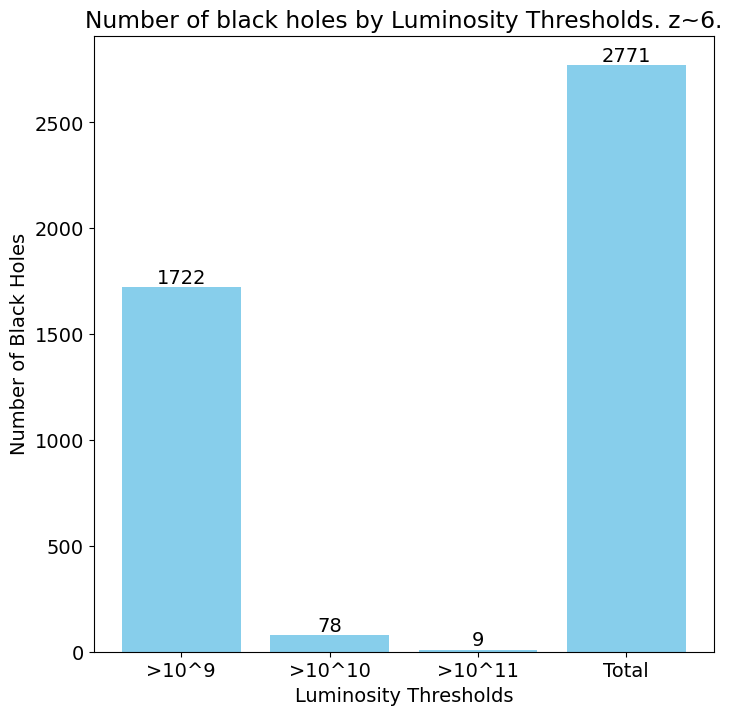

In [31]:
luminosities = bh_lum_sol

# Define the thresholds
thresholds = [1e9, 1e10, 1e11]

# Count the number of luminosities greater than each threshold
counts = [np.sum(luminosities > threshold) for threshold in thresholds]

# Total number count
total_count = len(luminosities)

# Append the total count to the counts list
counts.append(total_count)

# Labels for the bars
labels = ['>10^9', '>10^10', '>10^11', 'Total']

fig, ax = plt.subplots(figsize = (8,8))

# Create bar plot
bars = plt.bar(labels, counts, color='skyblue')

# Adding labels and title
plt.xlabel('Luminosity Thresholds')
plt.ylabel('Number of Black Holes')
plt.title('Number of black holes by Luminosity Thresholds. z~6.')

for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, 
             bar.get_height(), 
             count, 
             ha='center', 
             va='bottom')

# Show plot
plt.show()



In [37]:
MBII_z4_filename = "bhprops_034.txt"
MBII_z4 = np.loadtxt(DATA_DIRECTORY + MBII_z4_filename)

bh_pos_x = np.copy(MBII_z4[:, 2])
bh_pos_y = np.copy(MBII_z4[:, 3])
bh_pos_z = np.copy(MBII_z4[:, 4])

bh_lum = np.copy(MBII_z4[:,8])
bh_lum_sol = bh_lum * 1.472 * 10 ** 12 # 1 M0/yr * 0.1 * c^2 equvialent to 1.472 x 10^12 L0

ind_10_9 = np.where(bh_lum_sol > 10 ** 9)

bh_pos_x = bh_pos_x[ind_10_9]
bh_pos_y = bh_pos_y[ind_10_9]
bh_pos_z = bh_pos_z[ind_10_9]

min_x = 0
max_x = 100000
min_y = 0
max_y = 100000

mult = 50 ## Number of random points used as a multiple of number of data points
z_bin_size = 5   ## Bin size used to produce a new z distribution of the random numbers
bin_size_ar = [50]  ## Bin size used for correlation function measurement

for bin_size in bin_size_ar:

    n_D = len(bh_pos_x)
    n_rand = mult * n_D
    rand_x = np.random.uniform(min_x, max_x, n_rand)
    rand_y = np.random.uniform(min_y, max_y, n_rand)

    #-------------------------------------------------------------------------------------------
    #Drawing random numbers for z from smoothed distribution of the data z vals

    z_bin = np.arange(np.min(bh_pos_z), np.max(bh_pos_z), z_bin_size)[:,np.newaxis]
    z_bin_mid = (z_bin + z_bin_size/2)[:-1]
    kde = KernelDensity(kernel="gaussian", bandwidth=50).fit(bh_pos_z[:,np.newaxis])
    log_dens = kde.score_samples(z_bin_mid)
    pdf = np.exp(log_dens)
    # ax.fill(pos_z[:, 0], pdf, fc="#AAAAFF")
    cdf = np.cumsum(pdf)
    cdf = cdf / np.max(cdf)
    cdf = np.insert(cdf, 0, 0)

    z_bin = z_bin.flatten()
    z_bin_mid = z_bin_mid.flatten()

    uni_val = np.random.rand(n_rand)
    bin_indices = np.searchsorted(cdf, uni_val)
    bin_edges = z_bin[bin_indices - 1]
    bin_diff = z_bin[bin_indices] - z_bin[bin_indices-1]
    bin_weights = (uni_val - cdf[bin_indices-1]) / (cdf[bin_indices] - cdf[bin_indices-1])
    rand_z = bin_edges + bin_weights * bin_diff

    ## ---------------------------------------------------------------------------------------------------------------------------------------------------

    bins = np.arange(0.01, 8000, bin_size)
    bin_mids = (bins[0:-1] + bins[1:])/2

    result_DD = DD(autocorr=1, nthreads=1, binfile=bins, X1 = bh_pos_x, Y1 = bh_pos_y, Z1 = bh_pos_z, periodic=False)
    result_RR = DD(autocorr=1, nthreads=1, binfile=bins, X1 = rand_x, Y1 = rand_y, Z1 = rand_z, periodic=False)
    result_DR = DD(autocorr=0, nthreads=1, binfile=bins, X1 = bh_pos_x, Y1 = bh_pos_y, Z1 = bh_pos_z, X2 = rand_x, Y2 = rand_y, Z2 = rand_z, periodic=False)

    DD_norm = (n_D * (n_D - 1))/2
    RR_norm = (n_rand * (n_rand - 1))/2
    DR_norm = n_D * n_rand

    DD_count = result_DD['npairs']/2
    RR_count = result_RR['npairs']/2
    DR_count = result_DR['npairs']

    LandSzal2pcf = (DD_count/DD_norm - 2 * DR_count/DR_norm + RR_count/RR_norm)/(RR_count/RR_norm)

    pois_err = (1 + LandSzal2pcf)/np.sqrt(np.minimum(DD_count, n_D))

from pandas import DataFrame

df = DataFrame({"r min":bins[0:-1], "r max":bins[1:], "DD count":DD_count, "DR count":DR_count, "RR count": RR_count, "Landy Szalay":LandSzal2pcf, "Pois Error":pois_err})

df.to_excel('MBIIz4_10_9.xlsx', sheet_name='sheet1', index=False)

# temp_popt, temp_pcov = spo.curve_fit(pow_func, bin_mids, LandSzal2pcf)
# _2pcf_fit_alpha = temp_popt[1]
# _2pcf_fit_A = temp_popt[0]
# ax.plot(bin_mids, pow_func(bin_mids, _2pcf_fit_A, _2pcf_fit_alpha), label=r"plaw Fit: A = {}, $\alpha = {}$".format(np.round(_2pcf_fit_A, 3), np.round(_2pcf_fit_alpha,3)))


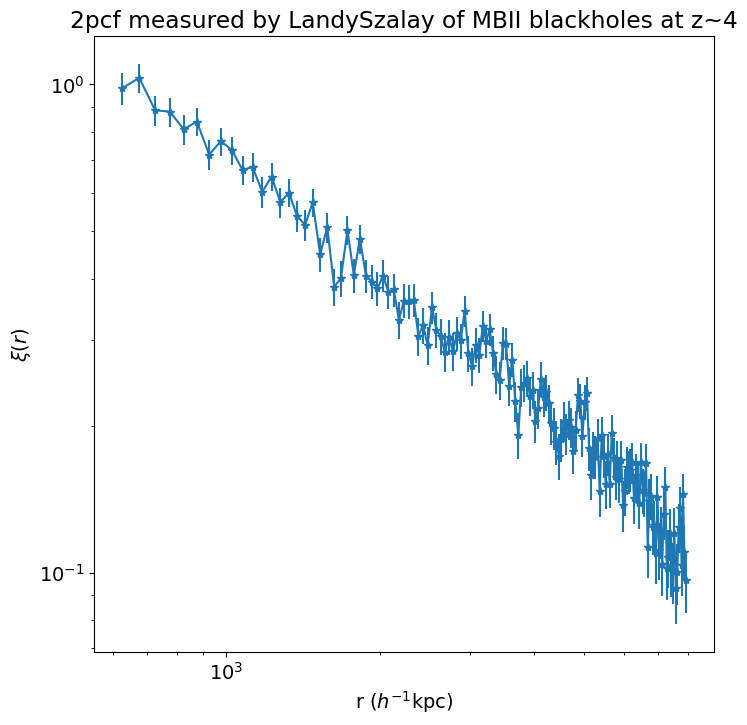

In [38]:
import pandas as pd

temp_z4clust = pd.read_excel('MBIIz4_10_9.xlsx', sheet_name='sheet1')
LandSzal2pcf = temp_z4clust['Landy Szalay']
bin_mids = (temp_z4clust['r min'] + temp_z4clust['r max'])/2
pois_err = temp_z4clust['Pois Error']

cutoff = np.argmax(LandSzal2pcf < 1)

fig, ax = plt.subplots(figsize = (8,8))
ax.errorbar(bin_mids[cutoff:], LandSzal2pcf[cutoff:], pois_err[cutoff:], fmt='-*')
ax.set_xlabel(r'r ($h^{-1}$kpc)')
ax.set_ylabel(r'$\xi(r)$')
ax.set_title("2pcf measured by LandySzalay of MBII blackholes at z~4")
ax.set_xscale('log')
ax.set_yscale('log')

In [48]:
# Model for the power law correlation function

def model(theta, s):
    s0, delta = theta
    return np.power(s/s0, -delta)

model_v = np.vectorize(model, excluded=['theta'])

def lnlike(theta, s_mid, xi_s, xi_s_error):
    xi_s_mod = model(theta, s_mid)

    Lnlike = np.sum(np.power((xi_s - xi_s_mod)/(xi_s_error), 2) * (-0.5))
    return Lnlike

def lnprior(theta):
    s0_min, s0_max = 400, 1300
    delta_min, delta_max = 0, 2

    s0, delta = theta
    if ((s0_min <= s0 <= s0_max) & (delta_min <= delta <= delta_max)):
        return 0.0
    else:
        return -np.inf

def lnprob(theta, s_mid, xi_s, xi_s_error):
    lp = lnprior(theta)
    if np.isinf(lp):
        return -np.inf
    else:
        return lp + lnlike(theta, s_mid, xi_s, xi_s_error)

(500000, 2)


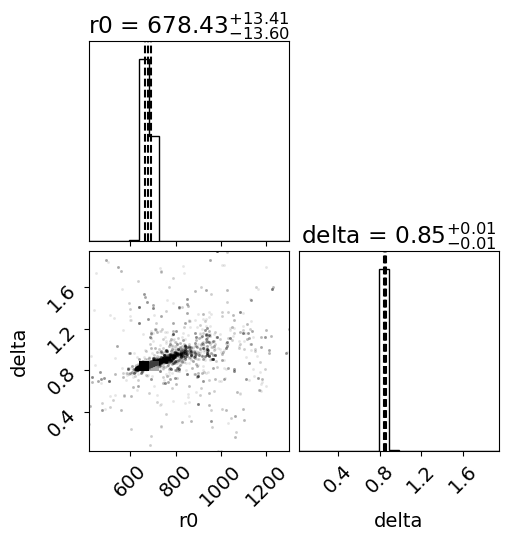

In [49]:
# Running the mcmc with the model to get the posterior distribution

import emcee
import matplotlib as mpl

initial = np.array([1000, 1.0])
ndim = len(initial)

nwalkers = 100

data = (bin_mids[cutoff:], LandSzal2pcf[cutoff:], pois_err[cutoff:])

p0 = np.random.uniform(low = np.array([400, 0]), high = np.array([1300, 2]), size = (nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)
sampler.run_mcmc(p0, 1000);
sampler.reset()

sampler.run_mcmc(p0, 5000);

samples = sampler.flatchain
print(samples.shape)

import corner
mpl.rcParams['font.size'] = 14
labels = ['r0', 'delta']
fig = corner.corner(samples, show_titles=True, labels=labels, plot_datapoints=True, quantiles=[0.16, 0.5, 0.84])
plt.show()

In [43]:
#Looking at the acceptance ratio
print("Mean acceptance rate is: {0:1.2f}".format(np.mean(sampler.acceptance_fraction)))

Mean acceptance rate is: 0.66


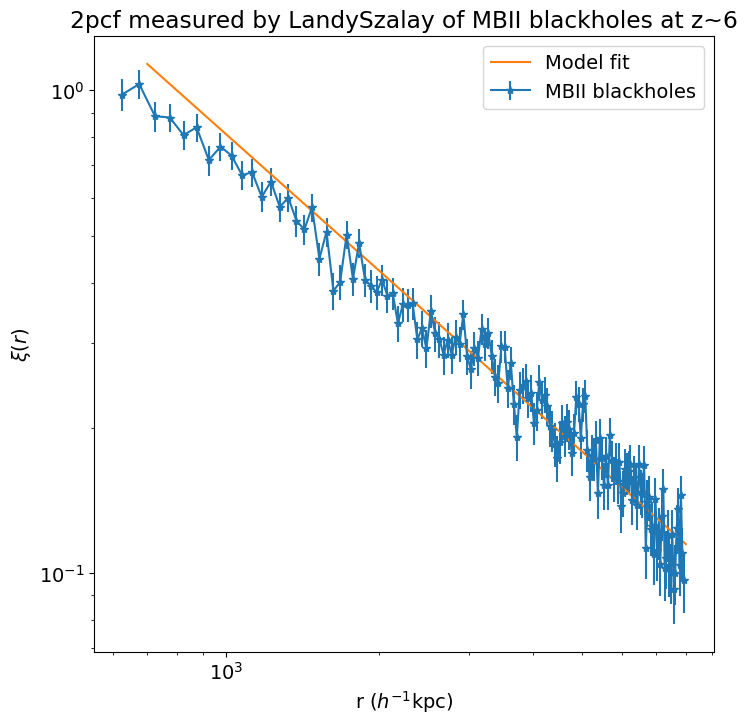

In [47]:
# Plotting the correlation function along with the fit from the mcmc

temp_s = np.linspace(700, 8000)
temp_xi = np.power(temp_s/800.85, -0.94)

fig, ax = plt.subplots(figsize = (8,8))
ax.errorbar(bin_mids[cutoff:], LandSzal2pcf[cutoff:], pois_err[cutoff:], fmt='-*', label="MBII blackholes")
ax.plot(temp_s, temp_xi, label="Model fit")
ax.set_xlabel(r'r ($h^{-1}$kpc)')
ax.set_ylabel(r'$\xi(r)$')
ax.set_title("2pcf measured by LandySzalay of MBII blackholes at z~6")
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_xlim(1000,8000)
ax.legend()

#### Testing the mcmc code from chatgpt

In [25]:
MBII_z4_filename = "bhprops_034.txt"
MBII_z4 = np.loadtxt(DATA_DIRECTORY + MBII_z4_filename)

bh_pos_x = np.copy(MBII_z4[:, 2])
bh_pos_y = np.copy(MBII_z4[:, 3])
bh_pos_z = np.copy(MBII_z4[:, 4])

bh_lum = np.copy(MBII_z4[:,8])
bh_lum_sol = bh_lum * 1.472 * 10 ** 12 # 1 M0/yr * 0.1 * c^2 equvialent to 1.472 x 10^12 L0

ind_10_9 = np.where(bh_lum_sol > 10 ** 9)

bh_pos_x = bh_pos_x[ind_10_9]
bh_pos_y = bh_pos_y[ind_10_9]
bh_pos_z = bh_pos_z[ind_10_9]

min_x = 0
max_x = 100000
min_y = 0
max_y = 100000

mult = 50 ## Number of random points used as a multiple of number of data points
z_bin_size = 5   ## Bin size used to produce a new z distribution of the random numbers
bin_size_ar = [50]  ## Bin size used for correlation function measurement

for bin_size in bin_size_ar:

    n_D = len(bh_pos_x)
    n_rand = mult * n_D
    rand_x = np.random.uniform(min_x, max_x, n_rand)
    rand_y = np.random.uniform(min_y, max_y, n_rand)

    #-------------------------------------------------------------------------------------------
    #Drawing random numbers for z from smoothed distribution of the data z vals

    z_bin = np.arange(np.min(bh_pos_z), np.max(bh_pos_z), z_bin_size)[:,np.newaxis]
    z_bin_mid = (z_bin + z_bin_size/2)[:-1]
    kde = KernelDensity(kernel="gaussian", bandwidth=50).fit(bh_pos_z[:,np.newaxis])
    log_dens = kde.score_samples(z_bin_mid)
    pdf = np.exp(log_dens)
    # ax.fill(pos_z[:, 0], pdf, fc="#AAAAFF")
    cdf = np.cumsum(pdf)
    cdf = cdf / np.max(cdf)
    cdf = np.insert(cdf, 0, 0)

    z_bin = z_bin.flatten()
    z_bin_mid = z_bin_mid.flatten()

    uni_val = np.random.rand(n_rand)
    bin_indices = np.searchsorted(cdf, uni_val)
    bin_edges = z_bin[bin_indices - 1]
    bin_diff = z_bin[bin_indices] - z_bin[bin_indices-1]
    bin_weights = (uni_val - cdf[bin_indices-1]) / (cdf[bin_indices] - cdf[bin_indices-1])
    rand_z = bin_edges + bin_weights * bin_diff

    ## ---------------------------------------------------------------------------------------------------------------------------------------------------

    bins = np.arange(0.01, 8000, bin_size)
    bin_mids = (bins[0:-1] + bins[1:])/2

    result_DD = DD(autocorr=1, nthreads=1, binfile=bins, X1 = bh_pos_x, Y1 = bh_pos_y, Z1 = bh_pos_z, periodic=False)
    result_RR = DD(autocorr=1, nthreads=1, binfile=bins, X1 = rand_x, Y1 = rand_y, Z1 = rand_z, periodic=False)
    result_DR = DD(autocorr=0, nthreads=1, binfile=bins, X1 = bh_pos_x, Y1 = bh_pos_y, Z1 = bh_pos_z, X2 = rand_x, Y2 = rand_y, Z2 = rand_z, periodic=False)

    DD_norm = (n_D * (n_D - 1))/2
    RR_norm = (n_rand * (n_rand - 1))/2
    DR_norm = n_D * n_rand

    DD_count = result_DD['npairs']/2
    RR_count = result_RR['npairs']/2
    DR_count = result_DR['npairs']

    LandSzal2pcf = (DD_count/DD_norm - 2 * DR_count/DR_norm + RR_count/RR_norm)/(RR_count/RR_norm)

    pois_err = (1 + LandSzal2pcf)/np.sqrt(np.minimum(DD_count, n_D))

from pandas import DataFrame

df = DataFrame({"r min":bins[0:-1], "r max":bins[1:], "DD count":DD_count, "DR count":DR_count, "RR count": RR_count, "Landy Szalay":LandSzal2pcf, "Pois Error":pois_err})

df.to_excel('MBIIz6_10_9.xlsx', sheet_name='sheet1', index=False)

# temp_popt, temp_pcov = spo.curve_fit(pow_func, bin_mids, LandSzal2pcf)
# _2pcf_fit_alpha = temp_popt[1]
# _2pcf_fit_A = temp_popt[0]
# ax.plot(bin_mids, pow_func(bin_mids, _2pcf_fit_A, _2pcf_fit_alpha), label=r"plaw Fit: A = {}, $\alpha = {}$".format(np.round(_2pcf_fit_A, 3), np.round(_2pcf_fit_alpha,3)))


/tmp/ipykernel_6728/1139979723.py:75: RuntimeWarning: divide by zero encountered in divide
  pois_err = (1 + LandSzal2pcf)/np.sqrt(np.minimum(DD_count, n_D))


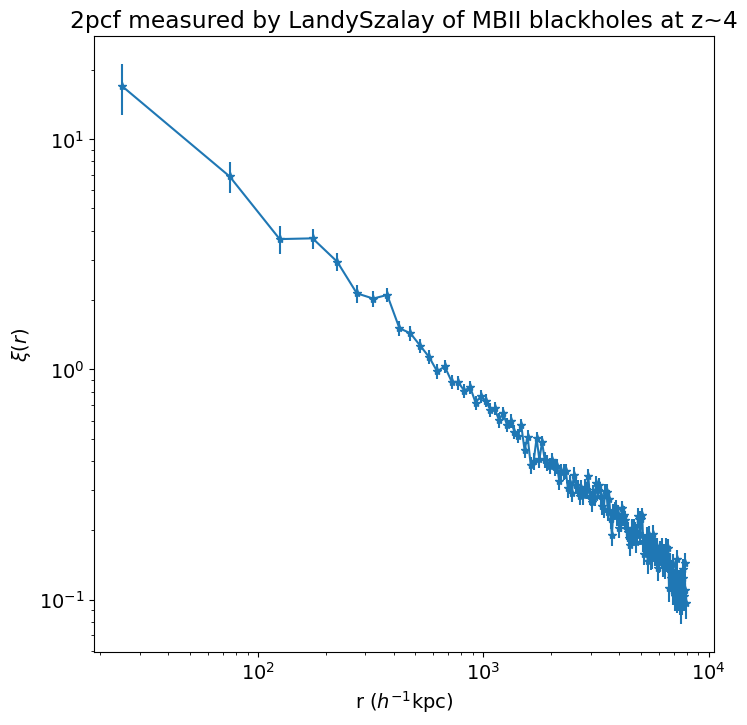

In [53]:
import pandas as pd

temp_z4clust = pd.read_excel('MBIIz4_10_9.xlsx', sheet_name='sheet1')
LandSzal2pcf = temp_z4clust['Landy Szalay']
bin_mids = (temp_z4clust['r min'] + temp_z4clust['r max'])/2
pois_err = temp_z4clust['Pois Error']

# cutoff = np.argmax((LandSzal2pcf < 1) & (LandSzal2pcf >= 0))
cutoff = 0

fig, ax = plt.subplots(figsize = (8,8))
ax.errorbar(bin_mids[cutoff:], LandSzal2pcf[cutoff:], pois_err[cutoff:], fmt='-*')
ax.set_xlabel(r'r ($h^{-1}$kpc)')
ax.set_ylabel(r'$\xi(r)$')
ax.set_title("2pcf measured by LandySzalay of MBII blackholes at z~4")
ax.set_xscale('log')
ax.set_yscale('log')

100%|██████████| 2000/2000 [01:20<00:00, 24.94it/s]


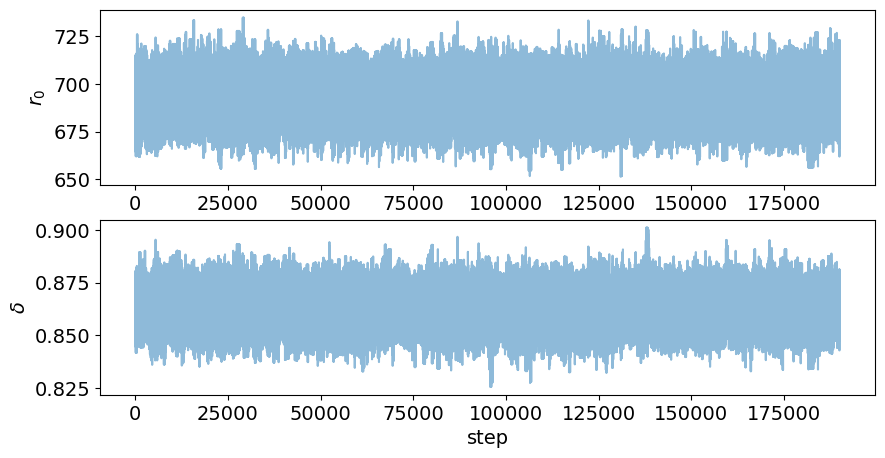

Best-fit parameters:
r0 = 692.2286021390938
delta = 0.8630119659975373


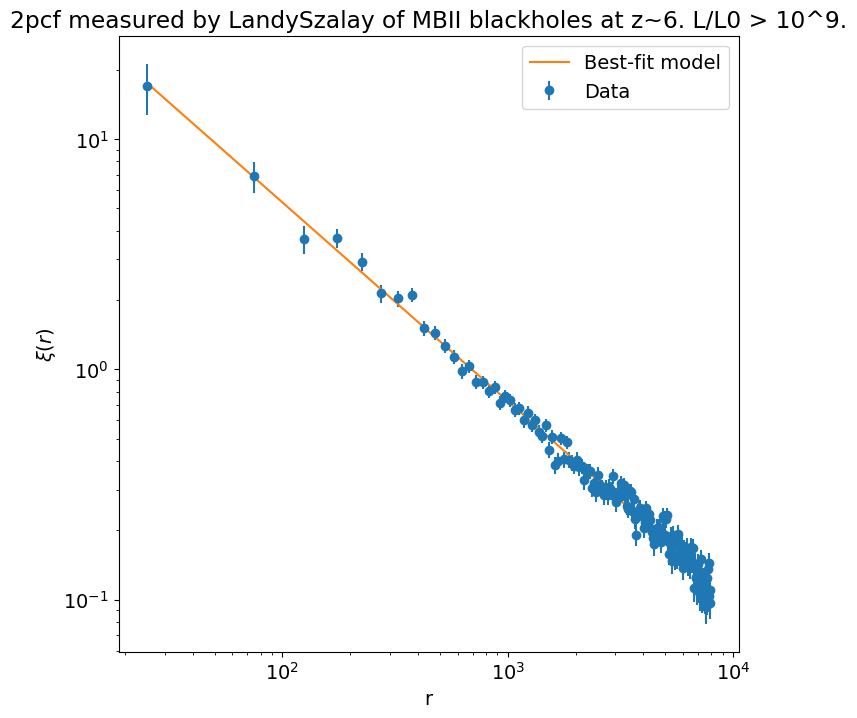

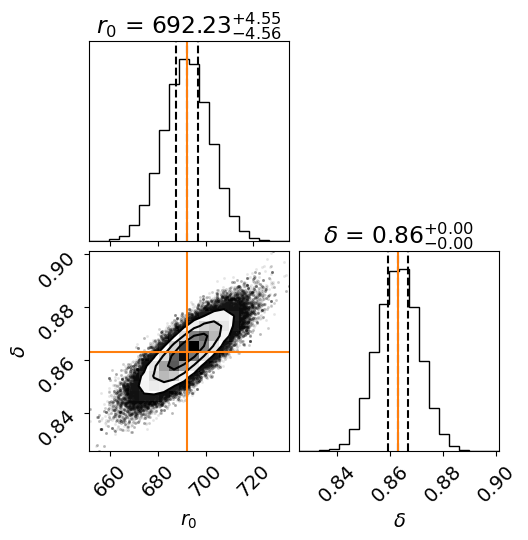

In [50]:
import numpy as np
import emcee
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Define the power law model
def power_law(r, r0, delta):
    return (r / r0) ** (-delta)

# Define the log likelihood function
def log_likelihood(theta, r, xi, xi_err):
    r0, delta = theta
    model = power_law(r, r0, delta)
    return -0.5 * np.sum(((xi - model) / xi_err) ** 2)

# Define the log prior function
def log_prior(theta):
    r0, delta = theta
    if 0 < r0 < 2000 and 0 < delta < 10:
        return 0.0
    return -np.inf

# Define the log probability function
def log_probability(theta, r, xi, xi_err):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, r, xi, xi_err)

# Load your data (replace with your actual data)
r_data = bin_mids[cutoff:]
xi_data = LandSzal2pcf[cutoff:]
xi_err_data = pois_err[cutoff:]

# Define initial guess for parameters
initial_guess = [1.0, 1.0]

# Minimize negative log likelihood to get initial guess for parameters
result = minimize(lambda *args: -log_likelihood(*args), initial_guess, args=(r_data, xi_data, xi_err_data))
initial_guess = result.x

# Set up the emcee sampler
ndim = 2  # Number of parameters
nwalkers = 100  # Number of walkers
nsteps = 2000  # Number of steps

# Initialize walkers
pos = initial_guess + 1e-4 * np.random.randn(nwalkers, ndim)

# Set up the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(r_data, xi_data, xi_err_data))

# Run the sampler
sampler.run_mcmc(pos, nsteps, progress=True);

# Get the samples
samples = sampler.get_chain(discard=100, flat=True)

# Plot the chains
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(samples[:, 0], alpha=0.5)
plt.ylabel(r'$r_0$')
plt.subplot(2, 1, 2)
plt.plot(samples[:, 1], alpha=0.5)
plt.ylabel(r'$\delta$')
plt.xlabel('step')
plt.show()

# Get the best-fit parameters
r0_best, delta_best = np.median(samples, axis=0)
print("Best-fit parameters:")
print("r0 =", r0_best)
print("delta =", delta_best)

# Plot the best-fit model
plt.figure(figsize=(8, 8))
plt.errorbar(r_data, xi_data, yerr=xi_err_data, fmt='o', label='Data')
plt.plot(r_data, power_law(r_data, r0_best, delta_best), label='Best-fit model')
plt.xlabel('r')
plt.ylabel(r'$\xi(r)$')
plt.title("2pcf measured by LandySzalay of MBII blackholes at z~6. L/L0 > 10^9.")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

# Plot the corner plot
import corner
labels = [r'$r_0$', r'$\delta$']
fig = corner.corner(samples, show_titles = True, labels=labels, plot_datapoints=True, quantiles=[0.32, 0.5, 0.68], figsize=(12,12))
corner.overplot_lines(fig, np.median(samples, axis=0), color="C1")
plt.show()

### Making the incompleteness map

Text(0, 0.5, 'normalized pdf')

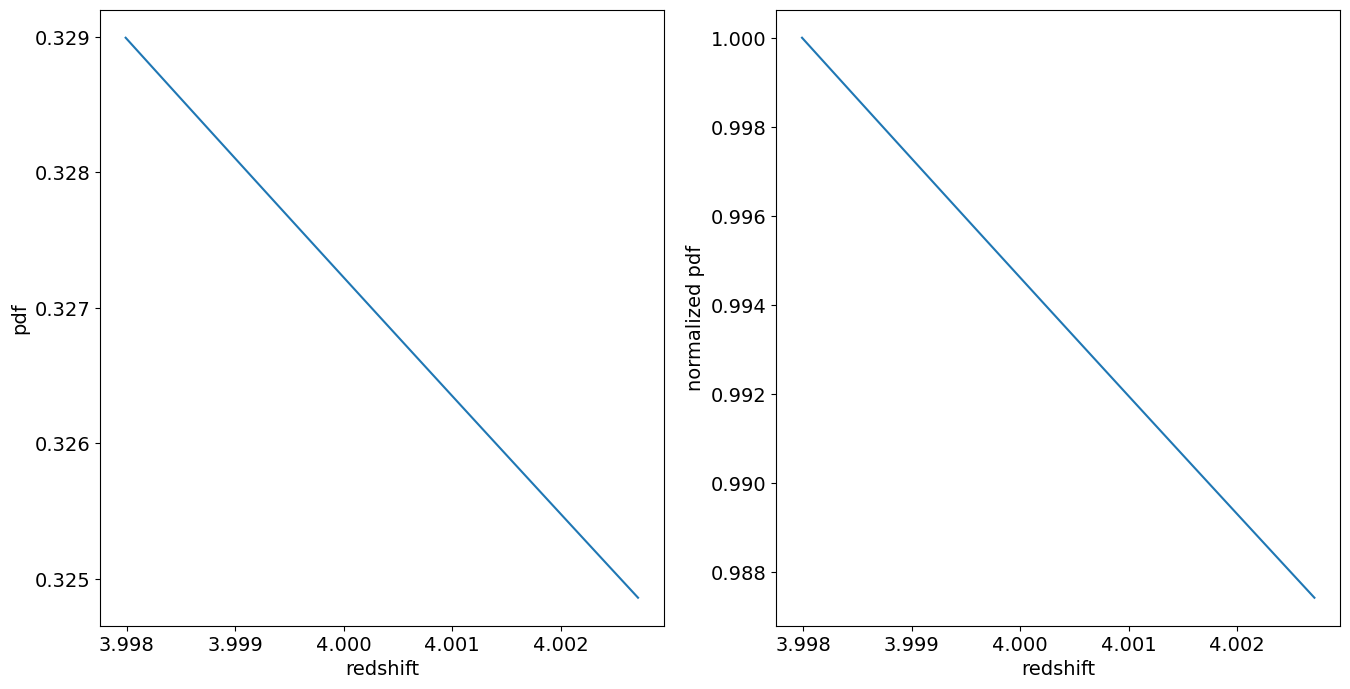

In [4]:
## Making of the incompleteness map
from astropy.io import ascii
import astropy.units as u
import astropy.cosmology.units as cu
from astropy.cosmology import WMAP3

DP2_DIRECTORY = "/home/vibin/MyFolder/WorkDesk/DP2/"

shen_file_name = DP2_DIRECTORY + "Data/shen_quasar_sample_datafile1.txt"
shen_data = ascii.read(shen_file_name)
sub_flag = shen_data.columns[8]
good_flag = shen_data.columns[9]
pos = np.where(sub_flag == 1)
pos_good = np.where(good_flag == 1)
red_col_shen_good = shen_data.columns[5][pos_good].value

z_data = red_col_shen_good[:, np.newaxis]
kde_model = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(z_data)

z_bin_size_inc = 50 # This z is the z axis not redshift
z_bin_new = np.arange(np.min(bh_pos_z), np.max(bh_pos_z), z_bin_size_inc)
z_bin_mid_new = (z_bin_new + z_bin_size_inc/2)[:-1]

start_red = 4.0 #Starting redshift
start_dist = np.round((start_red * cu.redshift).to(u.Mpc, cu.redshift_distance(WMAP3, kind="comoving")))  #Distance in Mpc corresponding to starting redshift
red_mids = (start_dist + z_bin_mid_new * np.power(10.0, -3) * u.Mpc).to(cu.redshift, cu.redshift_distance(WMAP3, kind="comoving")) #Redshifts of the z_bin_mid_new offset values of start dist.
log_dens_shen = kde_model.score_samples(red_mids[:, np.newaxis])                                                                   #Note the z axis is just box coordinates in Mpc
pdf_shen = np.exp(log_dens_shen)  #Here we draw a n(z) distribution for these red_mids from the smoothed kde model.

pdf_shen_norm1 = pdf_shen/np.max(pdf_shen)

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16, 8))

ax1.plot(red_mids, pdf_shen)
ax2.plot(red_mids, pdf_shen_norm1)
ax1.set_xlabel("redshift")
ax1.set_ylabel('pdf')
ax2.set_xlabel("redshift")
ax2.set_ylabel("normalized pdf")

Text(0, 0.5, 'Exaggerated incompleteness map')

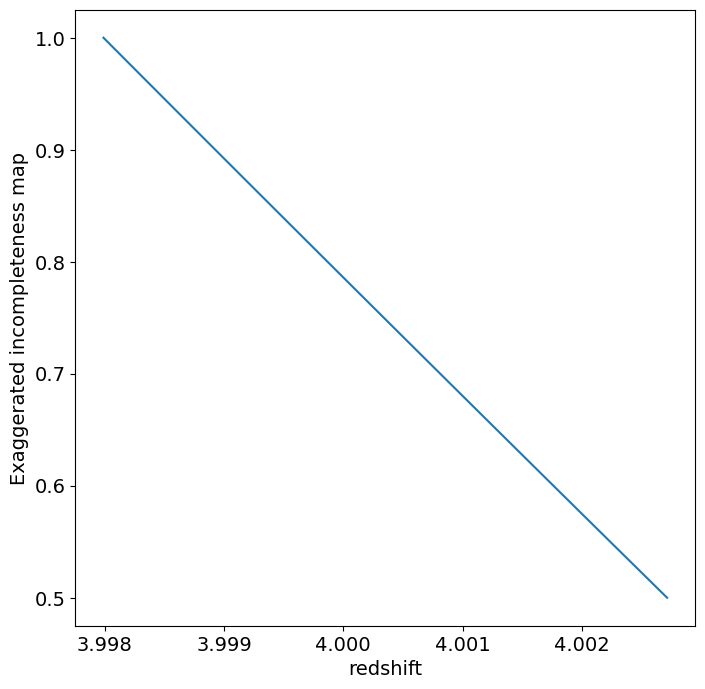

In [5]:
## Making of the exaggerated incompleteness map
min_pdf = np.min(pdf_shen_norm1)
max_pdf = np.max(pdf_shen_norm1)
pdf_shen_exag = 0.5 + (pdf_shen_norm1 - min_pdf)/(max_pdf - min_pdf) * 0.5

fig, ax = plt.subplots(figsize = (8,8))
ax.plot(red_mids, pdf_shen_exag)
ax.set_xlabel("redshift")
ax.set_ylabel('Exaggerated incompleteness map')

In [6]:
## Taking indices of subset of the MBII blackholes using the incompletness map prepared
mast_inc_temp_ind = np.array([], dtype=int)
for i, (z1, z2) in enumerate(zip(z_bin_new[:-1], z_bin_new[1:])):
    temp_ind = np.where((bh_pos_z > z1) & (bh_pos_z < z2))
    inc_temp_ind = np.random.choice(temp_ind[0], size=int(np.round(len(temp_ind[0]) * pdf_shen_exag[i])))
    # print(len(temp_ind[0]), len(inc_temp_ind), pdf_shen_exag[i])
    mast_inc_temp_ind = np.append(mast_inc_temp_ind, inc_temp_ind)

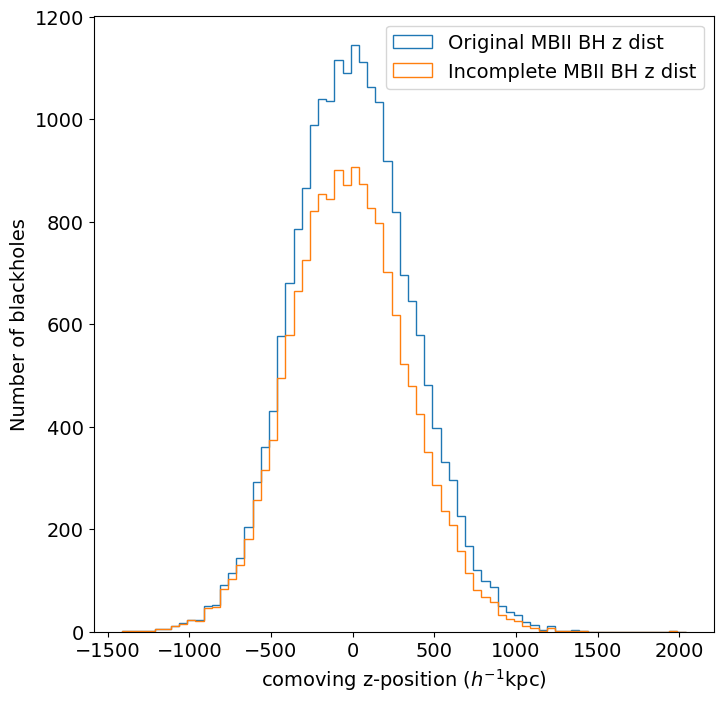

In [7]:
fig, ax = plt.subplots(figsize = (8,8))
ax.hist(bh_pos_z, bins=z_bin_new, histtype = 'step', label="Original MBII BH z dist");
ax.hist(bh_pos_z[mast_inc_temp_ind], bins=z_bin_new, histtype='step', label="Incomplete MBII BH z dist");
ax.set_xlabel(r'comoving z-position ($h^{-1}$kpc)')
ax.set_ylabel(r'Number of blackholes')
ax.legend()

### Incomplete 2pcf measurement

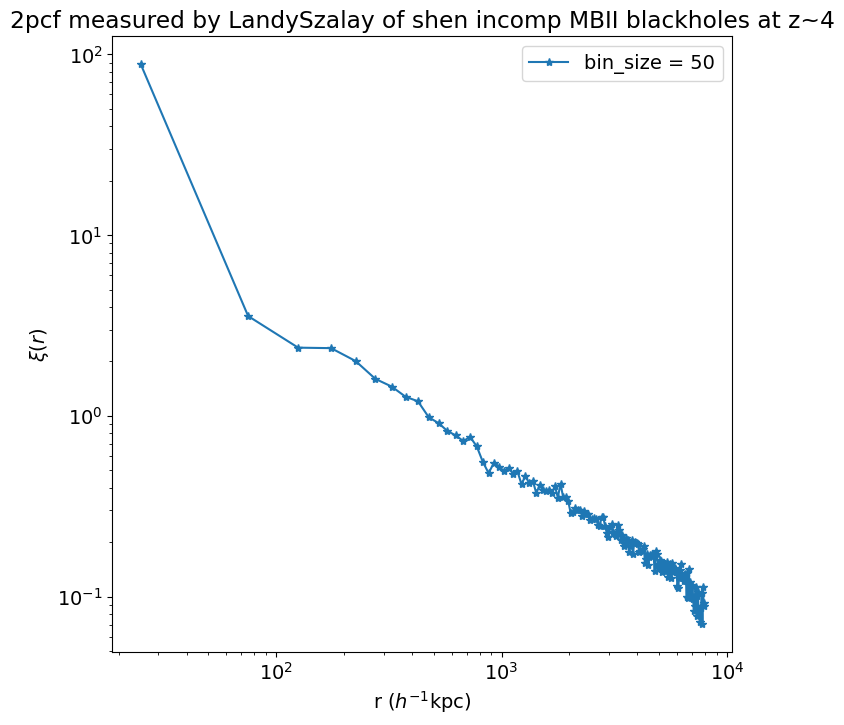

In [8]:
bh_pos_x_inc = np.copy(bh_pos_x[mast_inc_temp_ind])
bh_pos_y_inc = np.copy(bh_pos_y[mast_inc_temp_ind])
bh_pos_z_inc = np.copy(bh_pos_z[mast_inc_temp_ind])

min_x = 0
max_x = 100000
min_y = 0
max_y = 100000

fig, ax = plt.subplots(figsize = (8,8))

mult = 50 ## Number of random points used as a multiple of number of data points
z_bin_size = 5   ## Bin size used to produce a new z distribution of the random numbers
bin_size_ar = [50]  ## Bin size used for correlation function measurement

for bin_size in bin_size_ar:

    n_D = len(bh_pos_x_inc)
    n_rand = mult * n_D
    rand_x = np.random.uniform(min_x, max_x, n_rand)
    rand_y = np.random.uniform(min_y, max_y, n_rand)

    #-------------------------------------------------------------------------------------------
    #Drawing random numbers for z from smoothed distribution of the data z vals

    z_bin = np.arange(np.min(bh_pos_z_inc), np.max(bh_pos_z_inc), z_bin_size)[:,np.newaxis]
    z_bin_mid = (z_bin + z_bin_size/2)[:-1]
    kde = KernelDensity(kernel="gaussian", bandwidth=50).fit(bh_pos_z_inc[:,np.newaxis])
    log_dens = kde.score_samples(z_bin_mid)
    pdf = np.exp(log_dens)
    # ax.fill(pos_z[:, 0], pdf, fc="#AAAAFF")
    cdf = np.cumsum(pdf)
    cdf = cdf / np.max(cdf)
    cdf = np.insert(cdf, 0, 0)

    z_bin = z_bin.flatten()
    z_bin_mid = z_bin_mid.flatten()

    uni_val = np.random.rand(n_rand)
    bin_indices = np.searchsorted(cdf, uni_val)
    bin_edges = z_bin[bin_indices - 1]
    bin_diff = z_bin[bin_indices] - z_bin[bin_indices-1]
    bin_weights = (uni_val - cdf[bin_indices-1]) / (cdf[bin_indices] - cdf[bin_indices-1])
    rand_z = bin_edges + bin_weights * bin_diff

    ## ---------------------------------------------------------------------------------------------------------------------------------------------------

    bins = np.arange(0, 8000, bin_size)
    bin_mids = (bins[0:-1] + bins[1:])/2

    result_DD = DD(autocorr=1, nthreads=1, binfile=bins, X1 = bh_pos_x_inc, Y1 = bh_pos_y_inc, Z1 = bh_pos_z_inc, periodic=False)
    result_RR = DD(autocorr=1, nthreads=1, binfile=bins, X1 = rand_x, Y1 = rand_y, Z1 = rand_z, periodic=False)
    result_DR = DD(autocorr=0, nthreads=1, binfile=bins, X1 = bh_pos_x_inc, Y1 = bh_pos_y_inc, Z1 = bh_pos_z_inc, X2 = rand_x, Y2 = rand_y, Z2 = rand_z, periodic=False)

    DD_norm = (n_D * (n_D - 1))/2
    RR_norm = (n_rand * (n_rand - 1))/2
    DR_norm = n_D * n_rand

    DD_count = result_DD['npairs']/2
    RR_count = result_RR['npairs']/2
    DR_count = result_DR['npairs']

    LandSzal2pcf_inc = (DD_count/DD_norm - 2 * DR_count/DR_norm + RR_count/RR_norm)/(RR_count/RR_norm)

    ax.plot(bin_mids, LandSzal2pcf_inc, '-*', label="bin_size = {}".format(bin_size))

ax.set_xlabel(r'r ($h^{-1}$kpc)')
ax.set_ylabel(r'$\xi(r)$')
ax.set_title("2pcf measured by LandySzalay of shen incomp MBII blackholes at z~4")
ax.set_xscale('log')
ax.set_yscale('log')

# temp_popt, temp_pcov = spo.curve_fit(pow_func, bin_mids, LandSzal2pcf)
# _2pcf_fit_alpha = temp_popt[1]
# _2pcf_fit_A = temp_popt[0]
# ax.plot(bin_mids, pow_func(bin_mids, _2pcf_fit_A, _2pcf_fit_alpha), label=r"plaw Fit: A = {}, $\alpha = {}$".format(np.round(_2pcf_fit_A, 3), np.round(_2pcf_fit_alpha,3)))
ax.legend()

In [10]:
for i in range(len(bin_mids)):
    print(LandSzal2pcf_inc[i], "\n", end="")

88.44042273155549 
3.566401832270191 
2.385331950073683 
2.370510279289393 
2.0104067730024195 
1.6035657531485286 
1.453492441139004 
1.2754883659461016 
1.2053788080172396 
0.9825898157307217 
0.912046797685268 
0.8248147996640857 
0.7806331018196817 
0.7269855611587421 
0.7638682299055305 
0.6794966400464518 
0.5570784875042788 
0.4827432654078932 
0.5517821860265046 
0.5245651944079048 
0.49411037544771985 
0.5178346219735939 
0.47762563297696714 
0.49385488193142596 
0.41852296361864794 
0.4659928375146313 
0.4233841528100347 
0.4378717818192342 
0.37331529661496277 
0.41589776718821064 
0.3879462185935325 
0.3851181084192108 
0.3884258796395089 
0.3735501774825778 
0.40805153659344373 
0.35358579070325524 
0.42147376155056426 
0.35458912330197173 
0.35793770059373886 
0.337236117090146 
0.2894630316873542 
0.2925866320024079 
0.3093989127160726 
0.3010600104617035 
0.300669465493305 
0.28014715750471963 
0.29926172526649797 
0.2875178779062858 
0.2881557384392152 
0.2648338911461

In [3]:
_bin_mids = np.array([25, 75, 125, 175, 225, 275, 325, 375, 425, 475, 525, 575, 625, 675, 725, 775, 825, 875, 925, 975, 1025, 1075, 1125, 1175, 1225, 1275, 1325, 1375, 1425, 1475, 1525, 1575, 1625, 1675, 1725, 1775, 1825, 1875, 1925, 1975, 2025, 2075, 2125, 2175, 2225, 2275, 2325, 2375, 2425, 2475, 2525, 2575, 2625, 2675, 2725, 2775, 2825, 2875, 2925, 2975, 3025, 3075, 3125, 3175, 3225, 3275, 3325, 3375, 3425, 3475, 3525, 3575, 3625, 3675, 3725, 3775, 3825, 3875, 3925, 3975, 4025, 4075, 4125, 4175, 4225, 4275, 4325, 4375, 4425, 4475, 4525, 4575, 4625, 4675, 4725, 4775, 4825, 4875, 4925, 4975, 5025, 5075, 5125, 5175, 5225, 5275, 5325, 5375, 5425, 5475, 5525, 5575, 5625, 5675, 5725, 5775, 5825, 5875, 5925, 5975, 6025, 6075, 6125, 6175, 6225, 6275, 6325, 6375, 6425, 6475, 6525, 6575, 6625, 6675, 6725, 6775, 6825, 6875, 6925, 6975, 7025, 7075, 7125, 7175, 7225, 7275, 7325, 7375, 7425, 7475, 7525, 7575, 7625, 7675, 7725, 7775, 7825, 7875, 7925])
_2pcf_orig = np.array([49.1537664, 3.2292153, 2.1100743, 1.9066475, 1.8941988, 1.5344021, 1.3672074, 1.2962354, 1.1055929, 1.0235838, 0.9405753, 0.8158151, 0.7663315, 0.6969517, 0.7209991, 0.6228801, 0.5801021, 0.5263670, 0.5160945, 0.5061349, 0.5204667, 0.4831591, 0.4658017, 0.4321820, 0.4419620, 0.4576289, 0.4345864, 0.4186221, 0.3845348, 0.3927631, 0.3813153, 0.3867449, 0.3683344, 0.3601385, 0.3678411, 0.3351523, 0.3507618, 0.3216882, 0.3386703, 0.3233728, 0.3191107, 0.3047032, 0.3068572, 0.3023271, 0.3085203, 0.3002703, 0.2956290, 0.2731797, 0.2867092, 0.2736716, 0.2724269, 0.2663215, 0.2614618, 0.2530788, 0.2560501, 0.2510974, 0.2419787, 0.2242435, 0.2375808, 0.2348460, 0.2248741, 0.2403362, 0.2206616, 0.2275180, 0.2250116, 0.2285787, 0.2204830, 0.2036498, 0.2190099, 0.1993230, 0.2050522, 0.2130001, 0.2050778, 0.1835611, 0.1880286, 0.2001512, 0.1964003, 0.1906054, 0.1840180, 0.1889163, 0.1814200, 0.1867472, 0.1780086, 0.1854351, 0.1850280, 0.1841231, 0.1623262, 0.1720241, 0.1856534, 0.1621581, 0.1602007, 0.1667533, 0.1663287, 0.1603486, 0.1642493, 0.1613508, 0.1600206, 0.1559269, 0.1562317, 0.1488740, 0.1536773, 0.1515962, 0.1429507, 0.1402387, 0.1519526, 0.1540598, 0.1418772, 0.1283354, 0.1440865, 0.1401320, 0.1262579, 0.1416188, 0.1281813, 0.1451720, 0.1394064, 0.1339761, 0.1341830, 0.1411505, 0.1331686, 0.1358988, 0.1194871, 0.1357951, 0.1445017, 0.1244734, 0.1319732, 0.1278903, 0.1317066, 0.1306327, 0.1181695, 0.1139987, 0.1222181, 0.1151569, 0.1163982, 0.1176776, 0.1128740, 0.1225179, 0.1079438, 0.1055192, 0.0944957, 0.1040192, 0.1004304, 0.0981006, 0.0982300, 0.0961839, 0.1092469, 0.1024026, 0.1039166, 0.1042435, 0.1063538, 0.1000159, 0.0984503, 0.0891298, 0.0884676, 0.1019073, 0.0932476, 0.0915141, 0.1037781, 0.0926657, 0.0937249])
_2pcf_inc = np.array([88.4404227, 3.5664018, 2.3853320, 2.3705103, 2.0104068, 1.6035658, 1.4534924, 1.2754884, 1.2053788, 0.9825898, 0.9120468, 0.8248148, 0.7806331, 0.7269856, 0.7638682, 0.6794966, 0.5570785, 0.4827433, 0.5517822, 0.5245652, 0.4941104, 0.5178346, 0.4776256, 0.4938549, 0.4185230, 0.4659928, 0.4233842, 0.4378718, 0.3733153, 0.4158978, 0.3879462, 0.3851181, 0.3884259, 0.3735502, 0.4080515, 0.3535858, 0.4214738, 0.3545891, 0.3579377, 0.3372361, 0.2894630, 0.2925866, 0.3093989, 0.3010600, 0.3006695, 0.2801472, 0.2992617, 0.2875179, 0.2881557, 0.2648339, 0.2685769, 0.2722679, 0.2693843, 0.2496171, 0.2466138, 0.2770498, 0.2747924, 0.2472481, 0.2258904, 0.2152576, 0.2438200, 0.2517747, 0.2290886, 0.2226655, 0.2156517, 0.2497978, 0.2348351, 0.2054772, 0.2206262, 0.1906978, 0.1959257, 0.2107744, 0.2062355, 0.1762575, 0.1914252, 0.2048889, 0.1727761, 0.1988248, 0.2016056, 0.1971725, 0.1962936, 0.1765468, 0.1801677, 0.1811181, 0.1841020, 0.1906122, 0.1533364, 0.1624646, 0.1728304, 0.1505164, 0.1649260, 0.1707842, 0.1731028, 0.1703481, 0.1684056, 0.1382057, 0.1793227, 0.1718429, 0.1524636, 0.1433900, 0.1593171, 0.1584547, 0.1377240, 0.1502625, 0.1408171, 0.1520118, 0.1388000, 0.1379891, 0.1557668, 0.1282510, 0.1352615, 0.1523417, 0.1270999, 0.1454779, 0.1538955, 0.1377496, 0.1432706, 0.1443325, 0.1377124, 0.1368740, 0.1142362, 0.1118378, 0.1270504, 0.1398697, 0.1512973, 0.1292558, 0.1293426, 0.1297093, 0.1224719, 0.1313676, 0.1330406, 0.1225112, 0.1003100, 0.1348763, 0.0984597, 0.1424638, 0.1007955, 0.1204953, 0.0999186, 0.1005496, 0.1158889, 0.0970495, 0.0839313, 0.0888456, 0.1023072, 0.1136474, 0.1004533, 0.0778591, 0.1063552, 0.0842070, 0.0855804, 0.0726715, 0.0863873, 0.0866969, 0.1042631, 0.0707551, 0.1127523, 0.0924933, 0.0893873])

/tmp/ipykernel_3091/2280961508.py:13: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0, 8000)


(18.74506909394356, 8000)

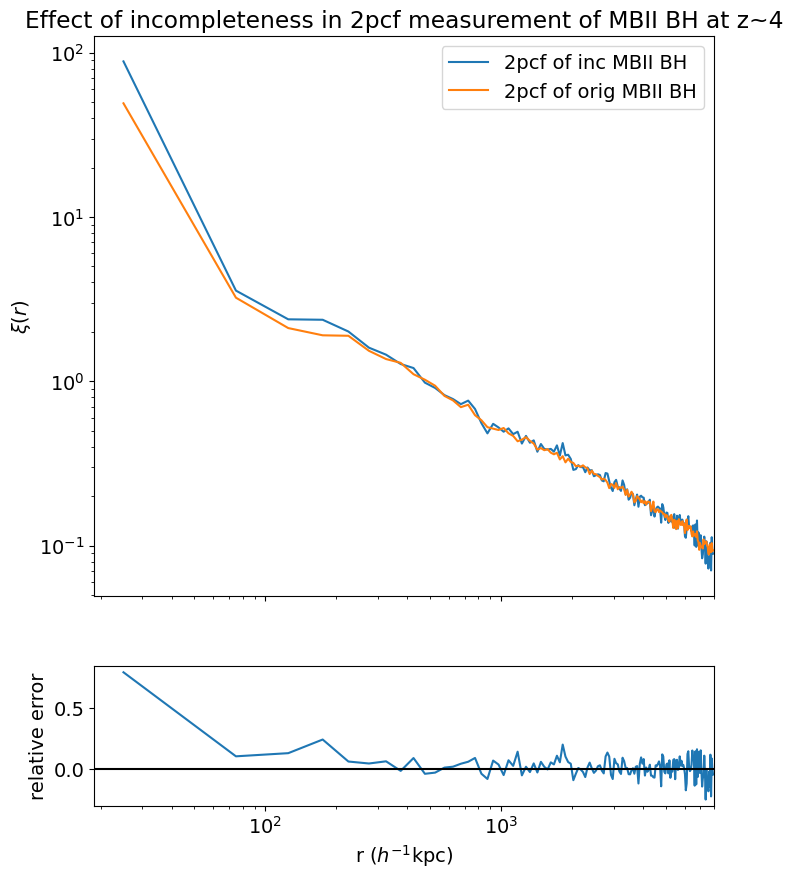

In [10]:
fig, (ax, ax2) = plt.subplots(2,1, figsize=(8,10), sharex=True, height_ratios=(8,2))
ax.plot(_bin_mids, _2pcf_inc, label="2pcf of inc MBII BH")
ax.plot(_bin_mids, _2pcf_orig, label="2pcf of orig MBII BH")
ax2.plot(_bin_mids, (_2pcf_inc - _2pcf_orig)/_2pcf_orig)
ax2.set_ylabel('relative error')
ax.set_xscale('log')
ax.set_yscale('log')
ax2.set_xlabel(r'r ($h^{-1}$kpc)')
ax2.axhline(color='black')
ax.set_ylabel(r'$\xi(r)$')
ax.set_title("Effect of incompleteness in 2pcf measurement of MBII BH at z~4")
ax.legend()
ax.set_xlim(0, 8000)

### Trying Richard's SDSS selection function

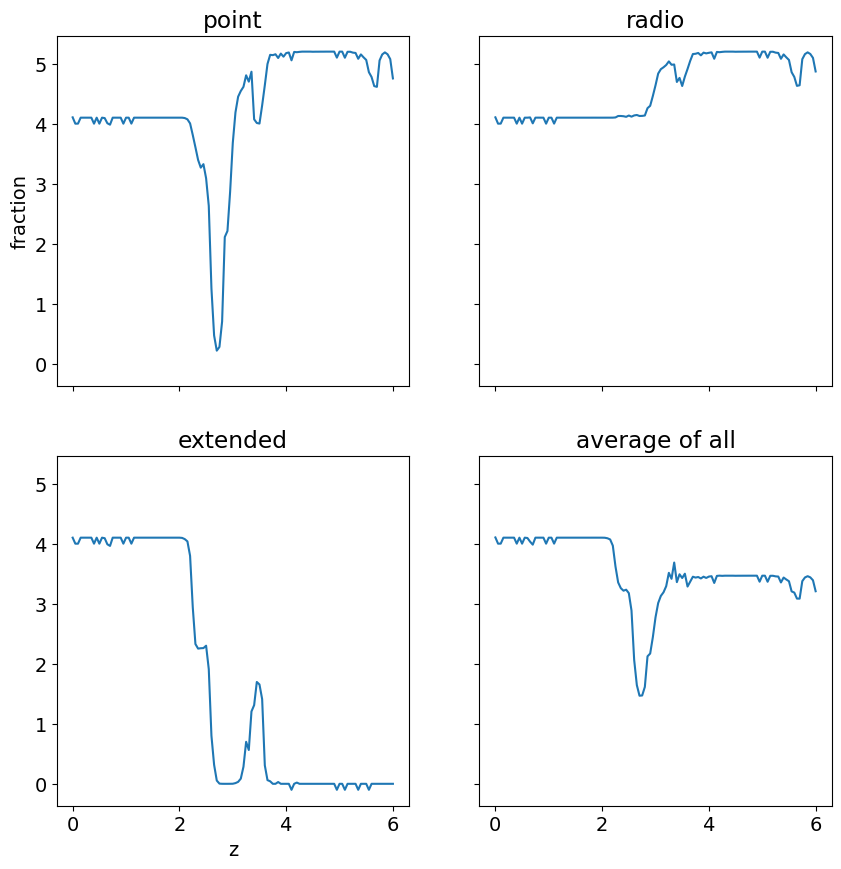

In [4]:
DP2_DIRECTORY = "/home/vibin/MyFolder/WorkDesk/DP2/"

sdss_sel_fun_file_name = DP2_DIRECTORY + 'Data/sdss_q_sel_fun_richards.dat'
sdss_sel_fun_file = open(sdss_sel_fun_file_name, 'r')
sdss_sel_fun = np.genfromtxt(sdss_sel_fun_file)

sel_fun_imag_col = sdss_sel_fun[:,0]
sel_fun_z_col = sdss_sel_fun[:,1]
sel_fun_point_col = sdss_sel_fun[:,2]
sel_fun_radio_col = sdss_sel_fun[:,3]
sel_fun_extended_col = sdss_sel_fun[:,4]

### selection function is given in the following way: 53 i magnitudes are there from 15.0 to 20.2, difference of 0.1, for each magnitude 121 z values 
# from 0.0 to 6.0 is given with difference of 0.05.

sel_fun_z = sel_fun_z_col[0:121]
sel_fun_imag = np.reshape(sel_fun_imag_col, (53,121))[:,0]
sel_fun_point_val = np.sum(np.reshape(sel_fun_point_col,(53, 121)), axis=0) * 0.1 # 
sel_fun_point_grid = np.reshape(sel_fun_point_col,(53, 121))
sel_fun_radio_val = np.sum(np.reshape(sel_fun_radio_col,(53, 121)), axis=0) * 0.1
sel_fun_ext_val = np.sum(np.reshape(sel_fun_extended_col,(53, 121)), axis=0) * 0.1

fig1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10,10), sharex=True, sharey=True)
ax1.plot(sel_fun_z, sel_fun_point_val)
ax1.set_title('point')
ax2.plot(sel_fun_z, sel_fun_radio_val)
ax2.set_title('radio')
ax3.plot(sel_fun_z, sel_fun_ext_val)
ax3.set_title('extended')
ax4.plot(sel_fun_z, (sel_fun_point_val + sel_fun_radio_val + sel_fun_ext_val)/3)
ax4.set_title('average of all')
ax3.set_xlabel('z')
ax1.set_ylabel('fraction')
plt.show()

### New incomplete 2pcf measurement with Richards completeness map

Text(0, 0.5, 'incompleteness')

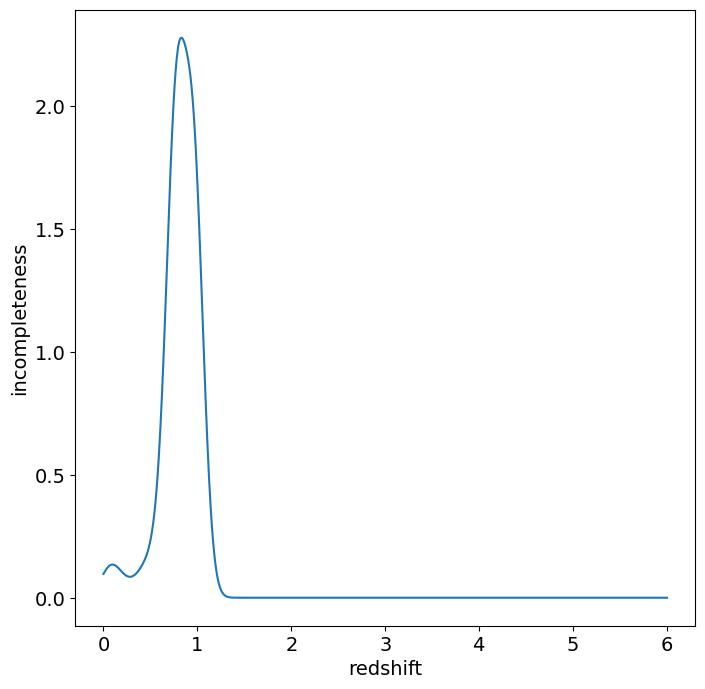

In [21]:
## Making of the incompleteness map
from astropy.io import ascii
import astropy.units as u
import astropy.cosmology.units as cu
from astropy.cosmology import WMAP3

inc_data = sel_fun_point_val[:, np.newaxis]
kde_model = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(inc_data)

z_bin_size_inc = 50 # This z is the z axis not redshift
z_bin_new = np.arange(np.min(bh_pos_z), np.max(bh_pos_z), z_bin_size_inc)
z_bin_mid_new = (z_bin_new + z_bin_size_inc/2)[:-1]

start_red = 4.0 #Starting redshift
start_dist = np.round((start_red * cu.redshift).to(u.Mpc, cu.redshift_distance(WMAP3, kind="comoving")))  #Distance in Mpc corresponding to starting redshift
# red_mids = (start_dist + z_bin_mid_new * np.power(10.0, -3) * u.Mpc).to(cu.redshift, cu.redshift_distance(WMAP3, kind="comoving")) #Redshifts of the z_bin_mid_new offset values of start dist.
red_mids = np.linspace(0, 6, 1000)
log_dens_rich = kde_model.score_samples(red_mids[:, np.newaxis])                                                                   #Note the z axis is just box coordinates in Mpc
inc_rich = np.exp(log_dens_rich)  #Here we draw a inc distribution for these red_mids from the smoothed kde model.

fig, ax = plt.subplots(figsize = (8, 8))

ax.plot(red_mids, inc_rich)
ax.set_xlabel("redshift")
ax.set_ylabel('incompleteness')

Text(0, 0.5, 'incompleteness')

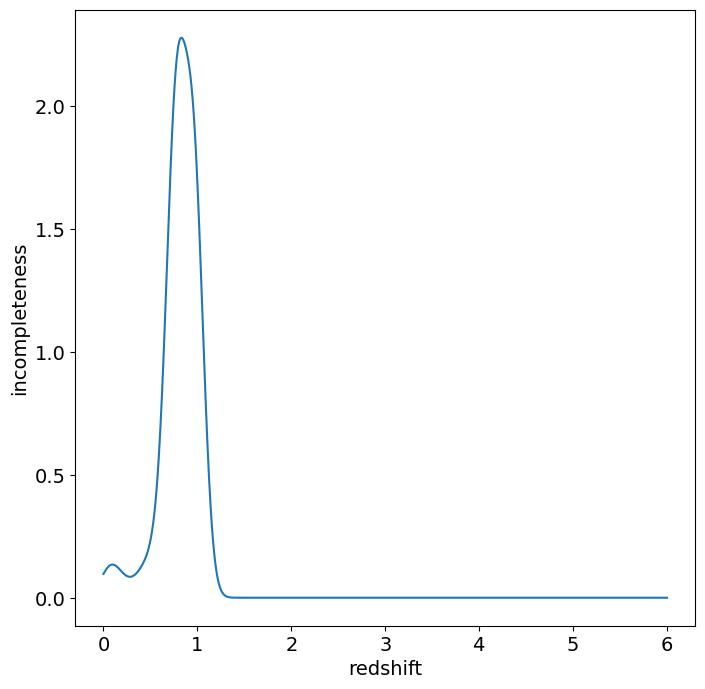

In [22]:
inc_data = sel_fun_point_val[:, np.newaxis]
kde_model = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(inc_data)

red_mids = np.linspace(0, 6, 1000)
log_dens_rich = kde_model.score_samples(red_mids[:, np.newaxis])                                                                   
inc_rich = np.exp(log_dens_rich)  #Here we draw a inc distribution for these red_mids from the smoothed kde model.

fig, ax = plt.subplots(figsize = (8, 8))

ax.plot(red_mids, inc_rich)
ax.set_xlabel("redshift")
ax.set_ylabel('incompleteness')

In [2]:
MBII_z4_filename = "bhprops_034.txt"
MBII_z4 = np.loadtxt(DATA_DIRECTORY + MBII_z4_filename)

bh_pos_x = np.copy(MBII_z4[:, 2])
bh_pos_y = np.copy(MBII_z4[:, 3])
bh_pos_z = np.copy(MBII_z4[:, 4])

In [5]:
## Making of the incompleteness map
from astropy.io import ascii
import astropy.units as u
import astropy.cosmology.units as cu
from astropy.cosmology import WMAP3

inc_data = sel_fun_point_val[:, np.newaxis]
kde_model = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(inc_data)

z_bin_size_inc = 50 # This z is the z axis not redshift
z_bin_new = np.arange(np.min(bh_pos_z), np.max(bh_pos_z), z_bin_size_inc)
z_bin_mid_new = (z_bin_new + z_bin_size_inc/2)[:-1]

start_red = 4.0 #Starting redshift
start_dist = np.round((start_red * cu.redshift).to(u.Mpc, cu.redshift_distance(WMAP3, kind="comoving")))  #Distance in Mpc corresponding to starting redshift
red_mids = (start_dist + z_bin_mid_new * np.power(10.0, -3) * u.Mpc).to(cu.redshift, cu.redshift_distance(WMAP3, kind="comoving")) #Redshifts of the z_bin_mid_new offset values of start dist.
red_bin_new = (start_dist + z_bin_new * np.power(10.0, -3) * u.Mpc).to(cu.redshift, cu.redshift_distance(WMAP3, kind="comoving"))

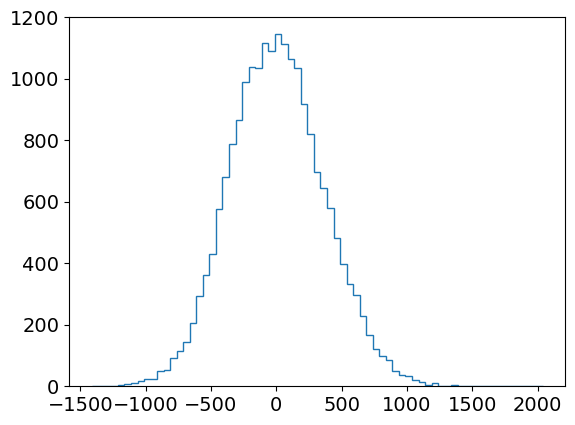

In [10]:
plt.hist(bh_pos_z, bins=z_bin_new, histtype='step');

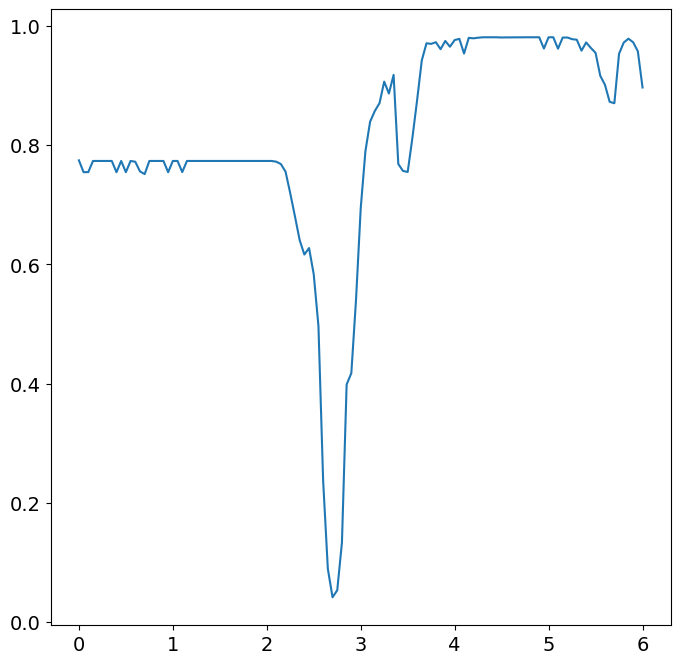

In [6]:
sel_fun_point_val = np.average(np.reshape(sel_fun_point_col,(53, 121)), axis=0)
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(sel_fun_z, sel_fun_point_val)

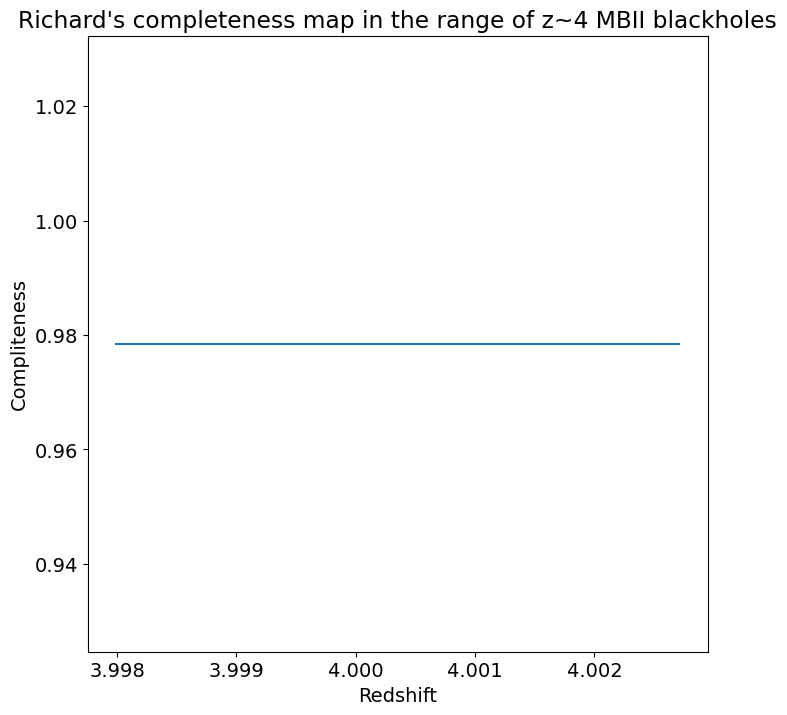

In [19]:
temp_diff = np.diff(sel_fun_z)[0]
sel_fun_z_bin = np.append(sel_fun_z, sel_fun_z[-1]+temp_diff) - temp_diff/2

sel_fun_subset = np.zeros(len(red_bin_new) - 1, dtype=int)
for i, z in enumerate(red_mids.value):
    sel_fun_subset[i] = np.searchsorted(sel_fun_z_bin, z) ##This is the completeness map in this case.

comp_map_richards_subset = sel_fun_point_val[sel_fun_subset]

# plt.plot(red_mids, sel_fun_point_val[sel_fun_subset])
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(red_mids, comp_map_richards_subset)
ax.set_ylabel("Compliteness")
ax.set_xlabel("Redshift")
ax.set_title("Richard's completeness map in the range of z~4 MBII blackholes")



In [20]:
## Taking indices of subset of the MBII blackholes using the incompletness map prepared
mast_inc_temp_ind = np.array([], dtype=int)
for i, (z1, z2) in enumerate(zip(z_bin_new[:-1], z_bin_new[1:])):
    temp_ind = np.where((bh_pos_z > z1) & (bh_pos_z < z2))
    inc_temp_ind = np.random.choice(temp_ind[0], size=int(np.round(len(temp_ind[0]) * comp_map_richards_subset[i]))) ##Here the completeness map is multiplied
    print(len(temp_ind[0]), int(np.round(len(temp_ind[0]) * comp_map_richards_subset[i])))
    # print(len(temp_ind[0]), len(inc_temp_ind), pdf_shen_exag[i])
    mast_inc_temp_ind = np.append(mast_inc_temp_ind, inc_temp_ind)

1 1
1 1
1 1
2 2
5 5
6 6
12 12
17 17
24 23
24 23
50 49
52 51
92 90
114 112
145 142
205 201
293 287
361 353
431 422
577 565
680 665
787 770
866 847
990 969
1040 1018
1036 1014
1117 1093
1091 1068
1145 1120
1113 1089
1064 1041
1035 1013
919 899
819 801
697 682
646 632
580 568
481 471
397 388
332 325
297 291
227 222
167 163
120 117
100 98
87 85
50 49
38 37
32 31
19 19
13 13
4 4
11 11
1 1
2 2
4 4
2 2
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 1
0 0


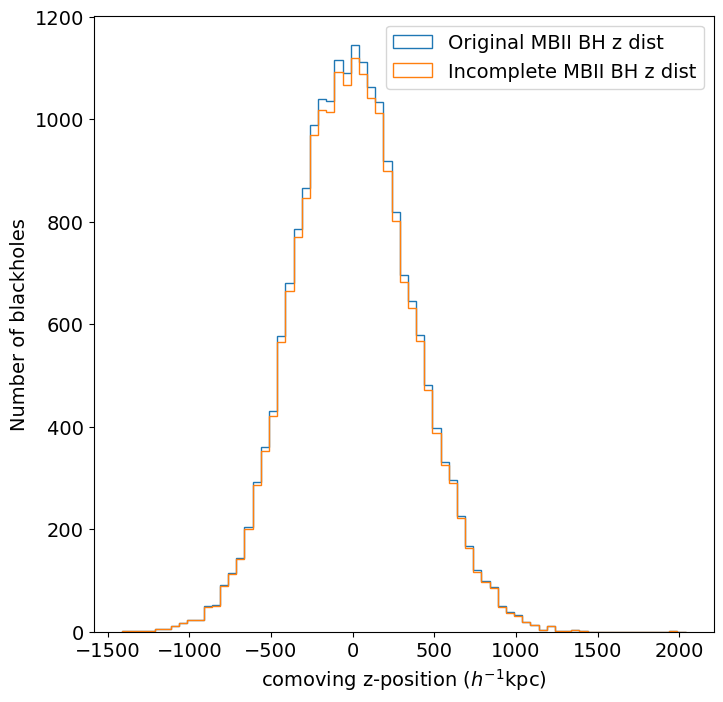

In [18]:
fig, ax = plt.subplots(figsize = (8,8))
ax.hist(bh_pos_z, bins=z_bin_new, histtype = 'step', label="Original MBII BH z dist");
ax.hist(bh_pos_z[mast_inc_temp_ind], bins=z_bin_new, histtype='step', label="Incomplete MBII BH z dist");
ax.set_xlabel(r'comoving z-position ($h^{-1}$kpc)')
ax.set_ylabel(r'Number of blackholes')
ax.legend()

In [12]:
bh_pos_x_inc = np.copy(bh_pos_x[mast_inc_temp_ind])
bh_pos_y_inc = np.copy(bh_pos_y[mast_inc_temp_ind])
bh_pos_z_inc = np.copy(bh_pos_z[mast_inc_temp_ind])

min_x = 0
max_x = 100000
min_y = 0
max_y = 100000

fig, ax = plt.subplots(figsize = (8,8))

mult = 50 ## Number of random points used as a multiple of number of data points
z_bin_size = 5   ## Bin size used to produce a new z distribution of the random numbers
bin_size_ar = [50]  ## Bin size used for correlation function measurement

for bin_size in bin_size_ar:

    n_D = len(bh_pos_x_inc)
    n_rand = mult * n_D
    rand_x = np.random.uniform(min_x, max_x, n_rand)
    rand_y = np.random.uniform(min_y, max_y, n_rand)

    #-------------------------------------------------------------------------------------------
    #Drawing random numbers for z from smoothed distribution of the data z vals

    z_bin = np.arange(np.min(bh_pos_z_inc), np.max(bh_pos_z_inc), z_bin_size)[:,np.newaxis]
    z_bin_mid = (z_bin + z_bin_size/2)[:-1]
    kde = KernelDensity(kernel="gaussian", bandwidth=50).fit(bh_pos_z_inc[:,np.newaxis])
    log_dens = kde.score_samples(z_bin_mid)
    pdf = np.exp(log_dens)
    # ax.fill(pos_z[:, 0], pdf, fc="#AAAAFF")
    cdf = np.cumsum(pdf)
    cdf = cdf / np.max(cdf)
    cdf = np.insert(cdf, 0, 0)

    z_bin = z_bin.flatten()
    z_bin_mid = z_bin_mid.flatten()

    uni_val = np.random.rand(n_rand)
    bin_indices = np.searchsorted(cdf, uni_val)
    bin_edges = z_bin[bin_indices - 1]
    bin_diff = z_bin[bin_indices] - z_bin[bin_indices-1]
    bin_weights = (uni_val - cdf[bin_indices-1]) / (cdf[bin_indices] - cdf[bin_indices-1])
    rand_z = bin_edges + bin_weights * bin_diff

    ## ---------------------------------------------------------------------------------------------------------------------------------------------------

    bins = np.arange(0, 8000, bin_size)
    bin_mids = (bins[0:-1] + bins[1:])/2

    result_DD = DD(autocorr=1, nthreads=1, binfile=bins, X1 = bh_pos_x_inc, Y1 = bh_pos_y_inc, Z1 = bh_pos_z_inc, periodic=False)
    result_RR = DD(autocorr=1, nthreads=1, binfile=bins, X1 = rand_x, Y1 = rand_y, Z1 = rand_z, periodic=False)
    result_DR = DD(autocorr=0, nthreads=1, binfile=bins, X1 = bh_pos_x_inc, Y1 = bh_pos_y_inc, Z1 = bh_pos_z_inc, X2 = rand_x, Y2 = rand_y, Z2 = rand_z, periodic=False)

    DD_norm = (n_D * (n_D - 1))/2
    RR_norm = (n_rand * (n_rand - 1))/2
    DR_norm = n_D * n_rand

    DD_count = result_DD['npairs']/2
    RR_count = result_RR['npairs']/2
    DR_count = result_DR['npairs']

    LandSzal2pcf_inc = (DD_count/DD_norm - 2 * DR_count/DR_norm + RR_count/RR_norm)/(RR_count/RR_norm)

    ax.plot(bin_mids, LandSzal2pcf_inc, '-*', label="bin_size = {}".format(bin_size))

ax.set_xlabel(r'r ($h^{-1}$kpc)')
ax.set_ylabel(r'$\xi(r)$')
ax.set_title("2pcf measured by LandySzalay of shen incomp MBII blackholes at z~4")
ax.set_xscale('log')
ax.set_yscale('log')

# temp_popt, temp_pcov = spo.curve_fit(pow_func, bin_mids, LandSzal2pcf)
# _2pcf_fit_alpha = temp_popt[1]
# _2pcf_fit_A = temp_popt[0]
# ax.plot(bin_mids, pow_func(bin_mids, _2pcf_fit_A, _2pcf_fit_alpha), label=r"plaw Fit: A = {}, $\alpha = {}$".format(np.round(_2pcf_fit_A, 3), np.round(_2pcf_fit_alpha,3)))
ax.legend()

NameError: name 'mast_inc_temp_ind' is not defined

## Making a compined data set from the MBII blackholes and finding clustering

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Corrfunc.theory.DD import DD
from sklearn.neighbors import KernelDensity
from scipy.stats import norm
import scipy.optimize as spo

DATA_DIRECTORY = "/home/vibin/MyFolder/WorkDesk/DP2/PhdProjects/Complicor/Data/"

def pow_func(r, A, alpha):
    return A * np.power(r, -alpha)

font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 14}

import matplotlib
matplotlib.rc('font', **font)

In [2]:
## Reading the z~4 to z~10 

MBII_z4_filename = "bhprops_034.txt"
MBII_z4 = np.loadtxt(DATA_DIRECTORY + MBII_z4_filename)

bh_pos_x4 = np.copy(MBII_z4[:, 2])
bh_pos_y4 = np.copy(MBII_z4[:, 3])  #Redshift 4
bh_pos_z4 = np.copy(MBII_z4[:, 4])

MBII_z5_filename = "bhprops_029.txt"
MBII_z5 = np.loadtxt(DATA_DIRECTORY + MBII_z5_filename)

bh_pos_x5 = np.copy(MBII_z5[:, 2])
bh_pos_y5 = np.copy(MBII_z5[:, 3])  #Redshift 5
bh_pos_z5 = np.copy(MBII_z5[:, 4])

MBII_z6_filename = "bhprops_026.txt"
MBII_z6 = np.loadtxt(DATA_DIRECTORY + MBII_z6_filename)

bh_pos_x6 = np.copy(MBII_z6[:, 2])
bh_pos_y6 = np.copy(MBII_z6[:, 3])  #Redshift 6
bh_pos_z6 = np.copy(MBII_z6[:, 4])

MBII_z7_filename = "bhprops_024.txt"
MBII_z7 = np.loadtxt(DATA_DIRECTORY + MBII_z7_filename)

bh_pos_x7 = np.copy(MBII_z7[:, 2])
bh_pos_y7 = np.copy(MBII_z7[:, 3])  #Redshift 7
bh_pos_z7 = np.copy(MBII_z7[:, 4])

MBII_z8_filename = "bhprops_020.txt"
MBII_z8 = np.loadtxt(DATA_DIRECTORY + MBII_z8_filename)

bh_pos_x8 = np.copy(MBII_z8[:, 2])
bh_pos_y8 = np.copy(MBII_z8[:, 3])  #Redshift 8
bh_pos_z8 = np.copy(MBII_z8[:, 4])

MBII_z9_filename = "bhprops_019.txt"
MBII_z9 = np.loadtxt(DATA_DIRECTORY + MBII_z9_filename)

bh_pos_x9 = np.copy(MBII_z9[:, 2])
bh_pos_y9 = np.copy(MBII_z9[:, 3])  #Redshift 9
bh_pos_z9 = np.copy(MBII_z9[:, 4])

MBII_z10_filename = "bhprops_018.txt"
MBII_z10 = np.loadtxt(DATA_DIRECTORY + MBII_z10_filename)

bh_pos_x10 = np.copy(MBII_z10[:, 2])
bh_pos_y10 = np.copy(MBII_z10[:, 3])  #Redshift 10
bh_pos_z10 = np.copy(MBII_z10[:, 4])

In [3]:
## Making a master catalogue centered at 6 from the 4-10 catalogues
## Adding 7 and 8
bh_pos_x_master = np.concatenate((bh_pos_x7, bh_pos_x8))
bh_pos_y_master = np.concatenate((bh_pos_y7, bh_pos_y8))
const_of_add = np.max(bh_pos_z7) - np.min(bh_pos_z8) #This is the constant addition for extending the z axis of the catalogues
bh_pos_z_master = np.concatenate((bh_pos_z7, bh_pos_z8 + const_of_add))

## Adding 6 to 7,8

bh_pos_x_master = np.concatenate((bh_pos_x6, bh_pos_x_master))
bh_pos_y_master = np.concatenate((bh_pos_y6, bh_pos_y_master))
const_of_add = np.min(bh_pos_z_master) - np.max(bh_pos_z6)
bh_pos_z_master = np.concatenate((bh_pos_z6 + const_of_add, bh_pos_z_master))

## Adding 9 to 6,7,8

bh_pos_x_master = np.concatenate((bh_pos_x_master, bh_pos_x9))
bh_pos_y_master = np.concatenate((bh_pos_y_master, bh_pos_y9))
const_of_add = np.max(bh_pos_z_master) - np.min(bh_pos_z9)
bh_pos_z_master = np.concatenate((bh_pos_z_master, bh_pos_z9 + const_of_add))

## Adding 5 to 6,7,8,9

bh_pos_x_master = np.concatenate((bh_pos_x5, bh_pos_x_master))
bh_pos_y_master = np.concatenate((bh_pos_y5, bh_pos_y_master))
const_of_add = np.min(bh_pos_z_master) - np.max(bh_pos_z5)
bh_pos_z_master = np.concatenate((bh_pos_z5 + const_of_add, bh_pos_z_master))

## Adding 4 t0 5,6,7,8,9

bh_pos_x_master = np.concatenate((bh_pos_x4, bh_pos_x_master))
bh_pos_y_master = np.concatenate((bh_pos_y4, bh_pos_y_master))
const_of_add = np.min(bh_pos_z_master) - np.max(bh_pos_z4)
bh_pos_z_master = np.concatenate((bh_pos_z4 + const_of_add, bh_pos_z_master))

## Adding 10 to 4,5,6,7,8,9

bh_pos_x_master = np.concatenate((bh_pos_x_master, bh_pos_x10))
bh_pos_y_master = np.concatenate((bh_pos_y_master, bh_pos_y10))
const_of_add = np.max(bh_pos_z_master) - np.min(bh_pos_z10)
bh_pos_z_master = np.concatenate((bh_pos_z_master, bh_pos_z10 + const_of_add))

Text(0.5, 1.0, 'z coordinate distribution of the master catalog made by combining MBII BH')

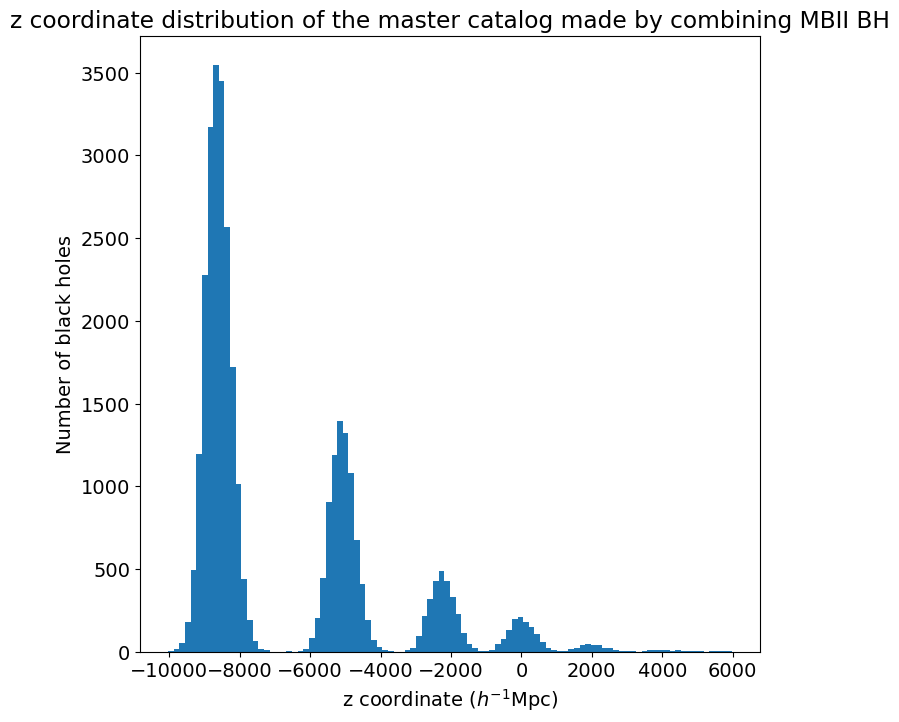

In [12]:
plt.figure(figsize=(8,8))
plt.hist(bh_pos_z_master, bins=100);
plt.xlabel(r'z coordinate ($h^{-1}$Mpc)')
plt.ylabel('Number of black holes')
plt.title('z coordinate distribution of the master catalog made by combining MBII BH')

In [30]:
print(np.max(bh_pos_z_master), np.min(bh_pos_z_master))

5973.4232 -10035.577


In [5]:
bh_pos_x = np.copy(bh_pos_x_master)
bh_pos_y = np.copy(bh_pos_y_master)
bh_pos_z = np.copy(bh_pos_z_master)

# bh_lum = np.copy(MBII_z4[:,8])
# bh_lum_sol = bh_lum * 1.472 * 10 ** 12 # 1 M0/yr * 0.1 * c^2 equvialent to 1.472 x 10^12 L0

# ind_10_9 = np.where(bh_lum_sol > 10 ** 9)

# bh_pos_x = bh_pos_x[ind_10_9]
# bh_pos_y = bh_pos_y[ind_10_9]
# bh_pos_z = bh_pos_z[ind_10_9]

min_x = 0
max_x = 100000
min_y = 0
max_y = 100000

mult = 50 ## Number of random points used as a multiple of number of data points
z_bin_size = 5   ## Bin size used to produce a new z distribution of the random numbers
bin_size_ar = [50]  ## Bin size used for correlation function measurement

for bin_size in bin_size_ar:

    n_D = len(bh_pos_x)
    n_rand = mult * n_D
    rand_x = np.random.uniform(min_x, max_x, n_rand)
    rand_y = np.random.uniform(min_y, max_y, n_rand)

    #-------------------------------------------------------------------------------------------
    #Drawing random numbers for z from smoothed distribution of the data z vals

    z_bin = np.arange(np.min(bh_pos_z), np.max(bh_pos_z), z_bin_size)[:,np.newaxis]
    z_bin_mid = (z_bin + z_bin_size/2)[:-1]
    kde = KernelDensity(kernel="gaussian", bandwidth=50).fit(bh_pos_z[:,np.newaxis])
    log_dens = kde.score_samples(z_bin_mid)
    pdf = np.exp(log_dens)
    # ax.fill(pos_z[:, 0], pdf, fc="#AAAAFF")
    cdf = np.cumsum(pdf)
    cdf = cdf / np.max(cdf)
    cdf = np.insert(cdf, 0, 0)

    z_bin = z_bin.flatten()
    z_bin_mid = z_bin_mid.flatten()

    uni_val = np.random.rand(n_rand)
    bin_indices = np.searchsorted(cdf, uni_val)
    bin_edges = z_bin[bin_indices - 1]
    bin_diff = z_bin[bin_indices] - z_bin[bin_indices-1]
    bin_weights = (uni_val - cdf[bin_indices-1]) / (cdf[bin_indices] - cdf[bin_indices-1])
    rand_z = bin_edges + bin_weights * bin_diff

    ## ---------------------------------------------------------------------------------------------------------------------------------------------------

    bins = np.arange(0.01, 8000, bin_size)
    bin_mids = (bins[0:-1] + bins[1:])/2

    result_DD = DD(autocorr=1, nthreads=1, binfile=bins, X1 = bh_pos_x, Y1 = bh_pos_y, Z1 = bh_pos_z, periodic=False)
    result_RR = DD(autocorr=1, nthreads=1, binfile=bins, X1 = rand_x, Y1 = rand_y, Z1 = rand_z, periodic=False)
    result_DR = DD(autocorr=0, nthreads=1, binfile=bins, X1 = bh_pos_x, Y1 = bh_pos_y, Z1 = bh_pos_z, X2 = rand_x, Y2 = rand_y, Z2 = rand_z, periodic=False)

    DD_norm = (n_D * (n_D - 1))/2
    RR_norm = (n_rand * (n_rand - 1))/2
    DR_norm = n_D * n_rand

    DD_count = result_DD['npairs']/2
    RR_count = result_RR['npairs']/2
    DR_count = result_DR['npairs']

    LandSzal2pcf = (DD_count/DD_norm - 2 * DR_count/DR_norm + RR_count/RR_norm)/(RR_count/RR_norm)

    pois_err = (1 + LandSzal2pcf)/np.sqrt(np.minimum(DD_count, n_D))

from pandas import DataFrame

df = DataFrame({"r min":bins[0:-1], "r max":bins[1:], "DD count":DD_count, "DR count":DR_count, "RR count": RR_count, "Landy Szalay":LandSzal2pcf, "Pois Error":pois_err})

df.to_excel('MBIIz_all.xlsx', sheet_name='sheet1', index=False)

# temp_popt, temp_pcov = spo.curve_fit(pow_func, bin_mids, LandSzal2pcf)
# _2pcf_fit_alpha = temp_popt[1]
# _2pcf_fit_A = temp_popt[0]
# ax.plot(bin_mids, pow_func(bin_mids, _2pcf_fit_A, _2pcf_fit_alpha), label=r"plaw Fit: A = {}, $\alpha = {}$".format(np.round(_2pcf_fit_A, 3), np.round(_2pcf_fit_alpha,3)))


[Warning] The CPU supports AVX2 but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports AVX but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports SSE4.2 but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports SSE4.1 but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports SSSE3 but the compiler does not.  Can you try another compiler?


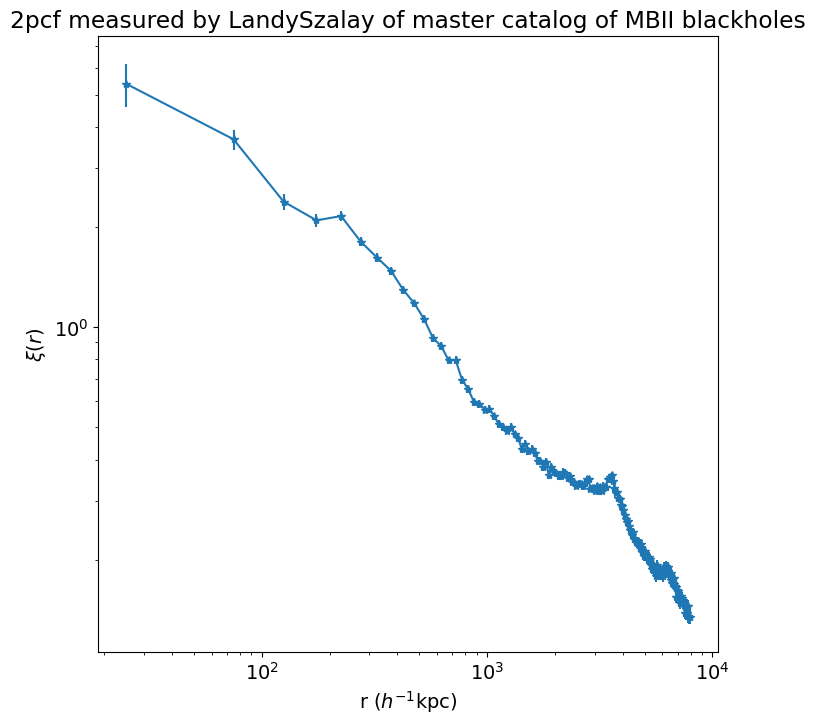

In [9]:
import pandas as pd

temp_z4clust = pd.read_excel('MBIIz_all.xlsx', sheet_name='sheet1')
LandSzal2pcf = temp_z4clust['Landy Szalay']
bin_mids = (temp_z4clust['r min'] + temp_z4clust['r max'])/2
pois_err = temp_z4clust['Pois Error']

# cutoff = np.argmax((LandSzal2pcf < 1) & (LandSzal2pcf >= 0))
cutoff = 0

fig, ax = plt.subplots(figsize = (8,8))
ax.errorbar(bin_mids[cutoff:], LandSzal2pcf[cutoff:], pois_err[cutoff:], fmt='-*')
ax.set_xlabel(r'r ($h^{-1}$kpc)')
ax.set_ylabel(r'$\xi(r)$')
ax.set_title("2pcf measured by LandySzalay of master catalog of MBII blackholes")
ax.set_xscale('log')
ax.set_yscale('log')

In [ ]:
min_z = np.min(bh_pos_z)
max_z = np.max(bh_pos_z)



In [ ]:


# Calculate the completeness along the z-axis
completeness = np.random.uniform(0, 1, size=len(z_bins) - 1)  # Example completeness values

# Normalize completeness to sum to 1
completeness /= np.sum(completeness)

# Choose the number of quasars to select in each bin based on completeness
num_quasars_per_bin = np.round(completeness * len(x_positions)).astype(int)

# Create a subset of quasars based on completeness
subset_indices = []
for i, num_quasars in enumerate(num_quasars_per_bin):
    z_mask = (z_positions >= z_bins[i]) & (z_positions < z_bins[i+1])
    if np.sum(z_mask) > num_quasars:
        indices = np.random.choice(np.where(z_mask)[0], size=num_quasars, replace=False)
    else:
        indices = np.where(z_mask)[0]
    subset_indices.extend(indices)

## All redshift combined plot

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from Corrfunc.theory.DD import DD
from sklearn.neighbors import KernelDensity
from scipy.stats import norm
import scipy.optimize as spo

DATA_DIRECTORY = "/home/vibin/MyFolder/WorkDesk/DP2/PhdProjects/Complicor/Data/"

def pow_func(r, A, alpha):
    return A * np.power(r, -alpha)

font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 14}

import matplotlib
matplotlib.rc('font', **font)

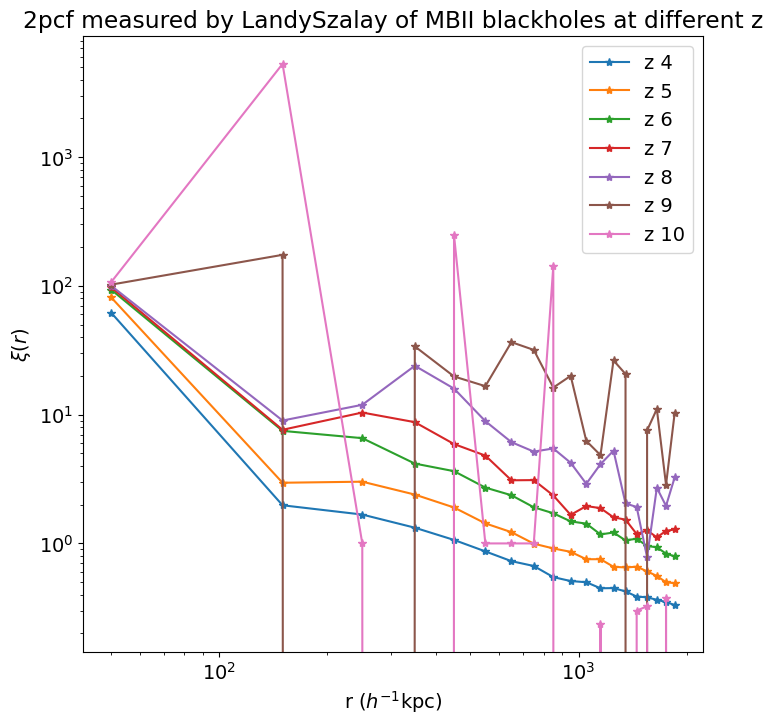

In [12]:
mult = 100 ## Number of random points used as a multiple of number of data points
z_bin_size = 5   ## Bin size used to produce a new z distribution of the random numbers
bin_size = 100  ## Bin size used for correlation function measurement

MBII_filename_list = ["bhprops_034.txt", "bhprops_029.txt", "bhprops_026.txt", "bhprops_024.txt", "bhprops_020.txt", "bhprops_019.txt", "bhprops_018.txt"]

fig, ax = plt.subplots(figsize = (8,8))

for i, MBII_z4_filename in enumerate(MBII_filename_list):
    MBII_z4 = np.loadtxt(DATA_DIRECTORY + MBII_z4_filename)

    bh_pos_x = np.copy(MBII_z4[:, 2])
    bh_pos_y = np.copy(MBII_z4[:, 3])
    bh_pos_z = np.copy(MBII_z4[:, 4])

    min_x = 0
    max_x = 100000
    min_y = 0
    max_y = 100000

    n_D = len(bh_pos_x)
    n_rand = mult * n_D
    rand_x = np.random.uniform(min_x, max_x, n_rand)
    rand_y = np.random.uniform(min_y, max_y, n_rand)

    #-------------------------------------------------------------------------------------------
    #Drawing random numbers for z from smoothed distribution of the data z vals

    z_bin = np.arange(np.min(bh_pos_z), np.max(bh_pos_z), z_bin_size)[:,np.newaxis]
    z_bin_mid = (z_bin + z_bin_size/2)[:-1]
    kde = KernelDensity(kernel="gaussian", bandwidth=50).fit(bh_pos_z[:,np.newaxis])
    log_dens = kde.score_samples(z_bin_mid)
    pdf = np.exp(log_dens)
    # ax.fill(pos_z[:, 0], pdf, fc="#AAAAFF")
    cdf = np.cumsum(pdf)
    cdf = cdf / np.max(cdf)
    cdf = np.insert(cdf, 0, 0)

    z_bin = z_bin.flatten()
    z_bin_mid = z_bin_mid.flatten()

    uni_val = np.random.rand(n_rand)
    bin_indices = np.searchsorted(cdf, uni_val)
    bin_edges = z_bin[bin_indices - 1]
    bin_diff = z_bin[bin_indices] - z_bin[bin_indices-1]
    bin_weights = (uni_val - cdf[bin_indices-1]) / (cdf[bin_indices] - cdf[bin_indices-1])
    rand_z = bin_edges + bin_weights * bin_diff

    #-------------------------------------------------------------------------------------------

    # print(len(bh_pos_x)/50)

    # n_bins = 400
    # fig, ax = plt.subplots(figsize = (8,8))
    # hist_data = plt.hist(bh_pos_x, bins=n_bins, histtype='step')[0];
    # ax.set_xlabel(r'comoving x-position ($h^{-1}$kpc)')
    # ax.set_ylabel(r'Number of blackholes')
    # ax.text(0.70, 0.85, r'Bin size = {} $h^{{-1}}$kpc'.format(np.round((max_x - min_x)/n_bins, 2)), transform = ax.transAxes)

    # fig2, ax2 = plt.subplots(figsize = (8,8))
    # hist_data = plt.hist(bh_pos_y, bins=n_bins, histtype='step')[0];
    # ax2.set_xlabel(r'comoving y-position ($h^{-1}$kpc)')
    # ax2.set_ylabel(r'Number of blackholes')
    # ax2.text(0.70, 0.85, r'Bin size = {} $h^{{-1}}$kpc'.format(np.round((max_y - min_y)/n_bins, 2)), transform = ax2.transAxes)

    # fig3, ax3 = plt.subplots(figsize = (8,8))
    # hist_data = plt.hist(bh_pos_z, bins=n_bins, histtype='step')[0];
    # ax3.set_xlabel(r'comoving z-position ($h^{-1}$kpc)')
    # ax3.set_ylabel(r'Number of blackholes')
    # ax3.text(0.70, 0.85, r'Bin size = {} $h^{{-1}}$kpc'.format(np.round((np.max(bh_pos_z) - np.min(bh_pos_z))/n_bins, 2)), transform = ax3.transAxes)

    ## ---------------------------------------------------------------------------------------------------------------------------------------------------

    bins = np.arange(0, 2000, bin_size)
    bin_mids = (bins[0:-1] + bins[1:])/2

    result_DD = DD(autocorr=1, nthreads=1, binfile=bins, X1 = bh_pos_x, Y1 = bh_pos_y, Z1 = bh_pos_z, periodic=False)
    result_RR = DD(autocorr=1, nthreads=1, binfile=bins, X1 = rand_x, Y1 = rand_y, Z1 = rand_z, periodic=False)
    result_DR = DD(autocorr=0, nthreads=1, binfile=bins, X1 = bh_pos_x, Y1 = bh_pos_y, Z1 = bh_pos_z, X2 = rand_x, Y2 = rand_y, Z2 = rand_z, periodic=False)

    DD_norm = (n_D * (n_D - 1))/2
    RR_norm = (n_rand * (n_rand - 1))/2
    DR_norm = n_D * n_rand

    DD_count = result_DD['npairs']/2
    RR_count = result_RR['npairs']/2
    DR_count = result_DR['npairs']

    LandSzal2pcf = (DD_count/DD_norm - 2 * DR_count/DR_norm + RR_count/RR_norm)/(RR_count/RR_norm)

    ax.plot(bin_mids, LandSzal2pcf, '-*', label="z "+str(i+4))

    # temp_popt, temp_pcov = spo.curve_fit(pow_func, bin_mids, LandSzal2pcf)
    # _2pcf_fit_alpha = temp_popt[1]
    # _2pcf_fit_A = temp_popt[0]
    # ax.plot(bin_mids, pow_func(bin_mids, _2pcf_fit_A, _2pcf_fit_alpha), label=r"plaw Fit: A = {}, $\alpha = {}$".format(np.round(_2pcf_fit_A, 3), np.round(_2pcf_fit_alpha,3)))
ax.set_xlabel(r'r ($h^{-1}$kpc)')
ax.set_ylabel(r'$\xi(r)$')
ax.set_title("2pcf measured by LandySzalay of MBII blackholes at different z")
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

## Data at z ~ 5

In [26]:
start_red = 10.0 #Starting redshift
start_dist = np.round((start_red * cu.redshift).to(u.Mpc, cu.redshift_distance(WMAP3, kind="comoving")))  #Distance in Mpc corresponding to starting redshift
red_mids = (start_dist + z_bin_mid_new * np.power(10.0, -3) * u.Mpc).to(cu.redshift, cu.redshift_distance(WMAP3, kind="comoving")) #Redshifts of the z_bin_mid_new offset values of start dist.
print(red_mids[0], red_mids[-1], red_mids[-1] - red_mids[0])

9.9918963393094 redshift 10.007173820412564 redshift 0.015277481103163737 redshift


160.72


/tmp/ipykernel_10026/1895688882.py:11: RuntimeWarning: overflow encountered in power
  return A * np.power(r, -alpha)
/tmp/ipykernel_10026/1895688882.py:11: RuntimeWarning: overflow encountered in multiply
  return A * np.power(r, -alpha)


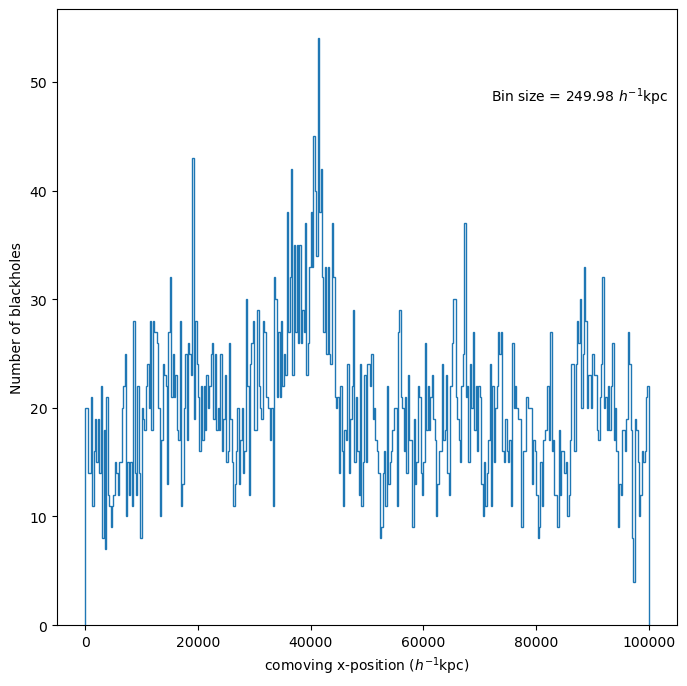

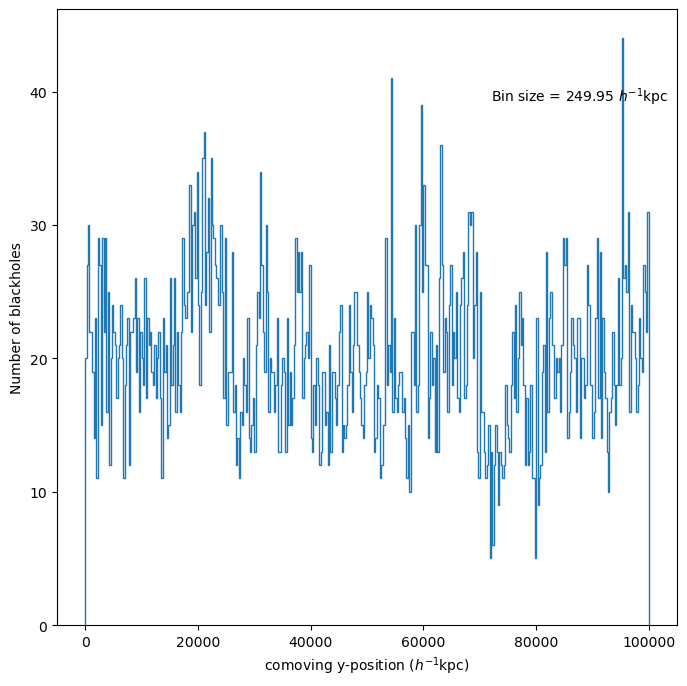

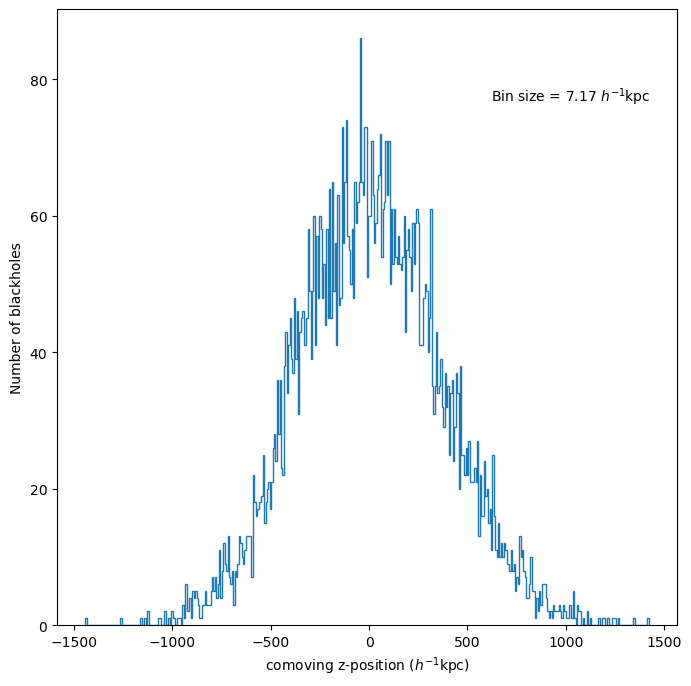

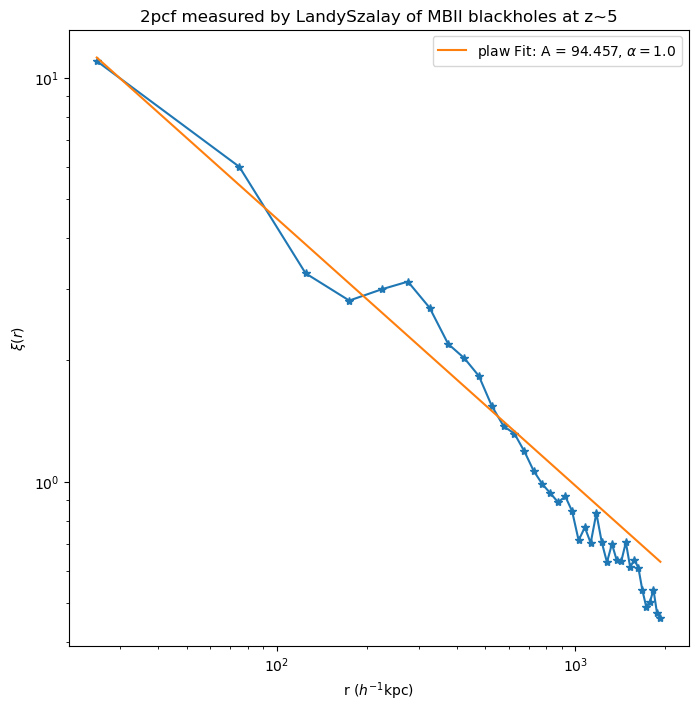

In [31]:
MBII_z5_filename = "bhprops_029.txt"
MBII_z5 = np.loadtxt(DATA_DIRECTORY + MBII_z5_filename)
redshift = 5

bh_pos_x = np.copy(MBII_z5[:, 2])
bh_pos_y = np.copy(MBII_z5[:, 3])
bh_pos_z = np.copy(MBII_z5[:, 4])
print(len(bh_pos_x)/50)

n_bins = 400
fig, ax = plt.subplots(figsize = (8,8))
hist_data = plt.hist(bh_pos_x, bins=n_bins, histtype='step')[0];
ax.set_xlabel(r'comoving x-position ($h^{-1}$kpc)')
ax.set_ylabel(r'Number of blackholes')
ax.text(0.70, 0.85, r'Bin size = {} $h^{{-1}}$kpc'.format(np.round((np.max(bh_pos_x) - np.min(bh_pos_x))/n_bins, 2)), transform = ax.transAxes)

fig2, ax2 = plt.subplots(figsize = (8,8))
hist_data = plt.hist(bh_pos_y, bins=n_bins, histtype='step')[0];
ax2.set_xlabel(r'comoving y-position ($h^{-1}$kpc)')
ax2.set_ylabel(r'Number of blackholes')
ax2.text(0.70, 0.85, r'Bin size = {} $h^{{-1}}$kpc'.format(np.round((np.max(bh_pos_y) - np.min(bh_pos_y))/n_bins, 2)), transform = ax2.transAxes)

fig3, ax3 = plt.subplots(figsize = (8,8))
hist_data = plt.hist(bh_pos_z, bins=n_bins, histtype='step')[0];
ax3.set_xlabel(r'comoving z-position ($h^{-1}$kpc)')
ax3.set_ylabel(r'Number of blackholes')
ax3.text(0.70, 0.85, r'Bin size = {} $h^{{-1}}$kpc'.format(np.round((np.max(bh_pos_z) - np.min(bh_pos_z))/n_bins, 2)), transform = ax3.transAxes)

mult = 10
n_D = len(bh_pos_x)
n_rand = mult * n_D
rand_x = np.random.uniform(np.min(bh_pos_x), np.max(bh_pos_x), n_rand)
rand_y = np.random.uniform(np.min(bh_pos_y), np.max(bh_pos_y), n_rand)

#-------------------------------------------------------------------------------------------
#Drawing random numbers for z from smoothed distribution of the data z vals
z_bin_size = 5

z_bin = np.arange(np.min(bh_pos_z), np.max(bh_pos_z), z_bin_size)[:,np.newaxis]
z_bin_mid = (z_bin + z_bin_size/2)[:-1]
kde = KernelDensity(kernel="gaussian", bandwidth=50).fit(bh_pos_z[:,np.newaxis])
log_dens = kde.score_samples(z_bin_mid)
pdf = np.exp(log_dens)
# ax.fill(pos_z[:, 0], pdf, fc="#AAAAFF")
cdf = np.cumsum(pdf)
cdf = cdf / np.max(cdf)
cdf = np.insert(cdf, 0, 0)

z_bin = z_bin.flatten()
z_bin_mid = z_bin_mid.flatten()

uni_val = np.random.rand(n_rand)
bin_indices = np.searchsorted(cdf, uni_val)
bin_edges = z_bin[bin_indices - 1]
bin_diff = z_bin[bin_indices] - z_bin[bin_indices-1]
bin_weights = (uni_val - cdf[bin_indices-1]) / (cdf[bin_indices] - cdf[bin_indices-1])
rand_z = bin_edges + bin_weights * bin_diff

#-------------------------------------------------------------------------------------------

bins = np.arange(0, 2000, 50)
bin_mids = (bins[0:-1] + bins[1:])/2

result_DD = DD(autocorr=1, nthreads=1, binfile=bins, X1 = bh_pos_x, Y1 = bh_pos_y, Z1 = bh_pos_z, periodic=False)
result_RR = DD(autocorr=1, nthreads=1, binfile=bins, X1 = rand_x, Y1 = rand_y, Z1 = rand_z, periodic=False)
result_DR = DD(autocorr=0, nthreads=1, binfile=bins, X1 = bh_pos_x, Y1 = bh_pos_y, Z1 = bh_pos_z, X2 = rand_x, Y2 = rand_y, Z2 = rand_z, periodic=False)

DD_norm = (n_D * (n_D - 1))/2
RR_norm = (n_rand * (n_rand - 1))/2
DR_norm = n_D * n_rand

DD_count = result_DD['npairs']/2
RR_count = result_RR['npairs']/2
DR_count = result_DR['npairs']

LandSzal2pcf = (DD_count/DD_norm - 2 * DR_count/DR_norm + RR_count/RR_norm)/(RR_count/RR_norm)

fig, ax = plt.subplots(figsize = (8,8))
ax.plot(bin_mids, LandSzal2pcf, '-*')
ax.set_xlabel(r'r ($h^{-1}$kpc)')
ax.set_ylabel(r'$\xi(r)$')
ax.set_title("2pcf measured by LandySzalay of MBII blackholes at z~{}".format(redshift))
ax.set_xscale('log')
ax.set_yscale('log')

temp_popt, temp_pcov = spo.curve_fit(pow_func, bin_mids, LandSzal2pcf)
_2pcf_fit_alpha = temp_popt[1]
_2pcf_fit_A = temp_popt[0]
ax.plot(bin_mids, pow_func(bin_mids, _2pcf_fit_A, _2pcf_fit_alpha), label=r"plaw Fit: A = {}, $\alpha = {}$".format(np.round(_2pcf_fit_A, 3), np.round(_2pcf_fit_alpha)))
ax.legend()

## Data at z ~ 6

55.42


/tmp/ipykernel_10026/1895688882.py:11: RuntimeWarning: overflow encountered in power
  return A * np.power(r, -alpha)
/tmp/ipykernel_10026/1895688882.py:11: RuntimeWarning: overflow encountered in multiply
  return A * np.power(r, -alpha)


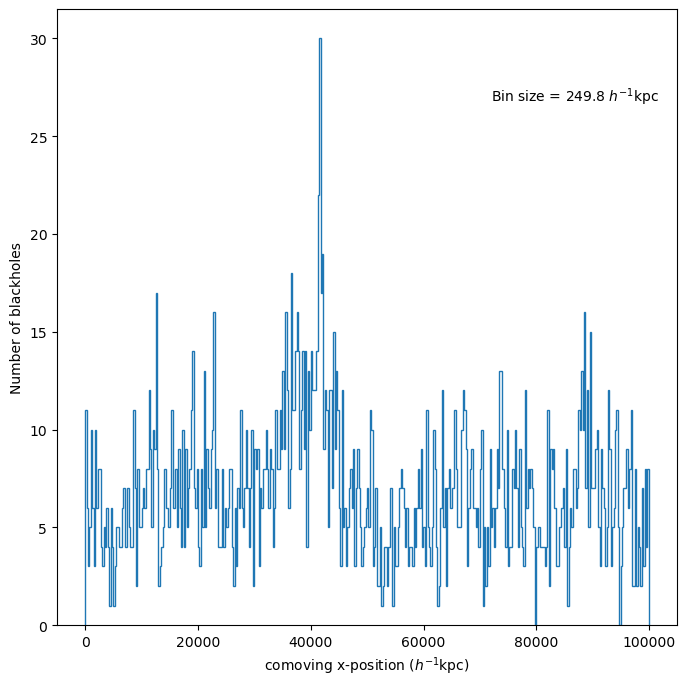

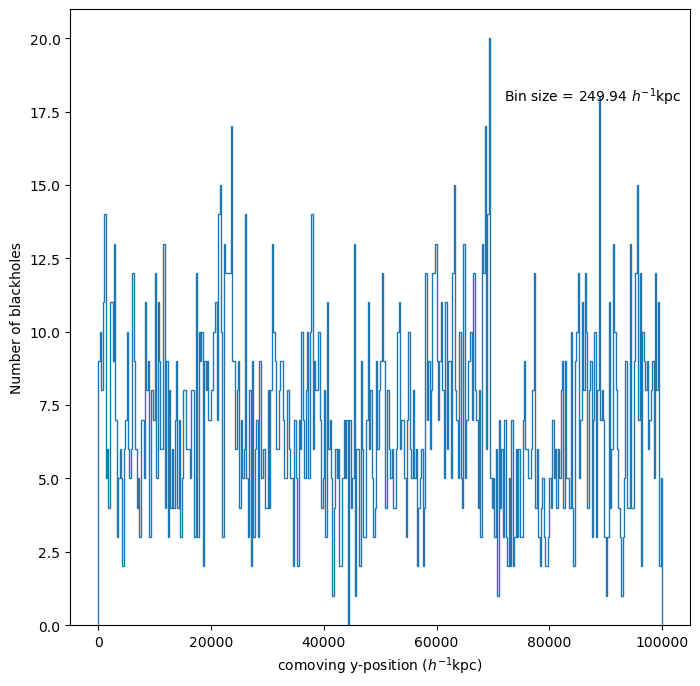

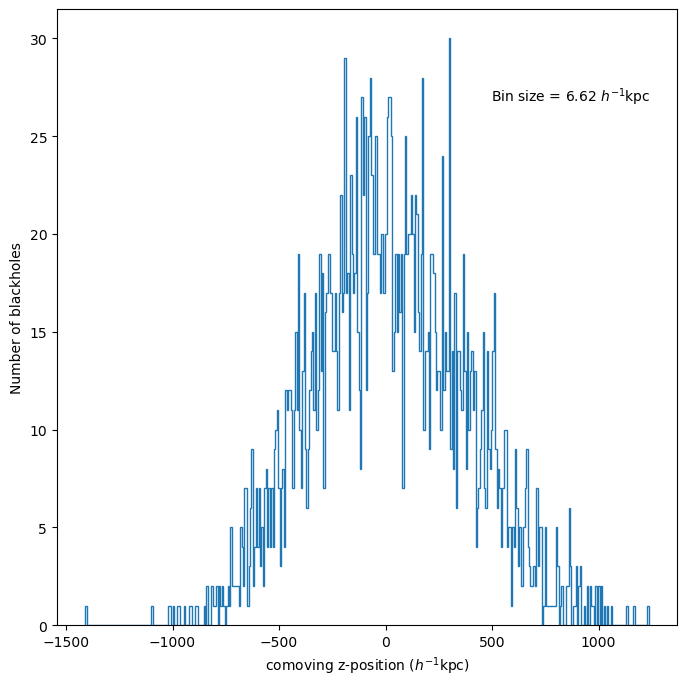

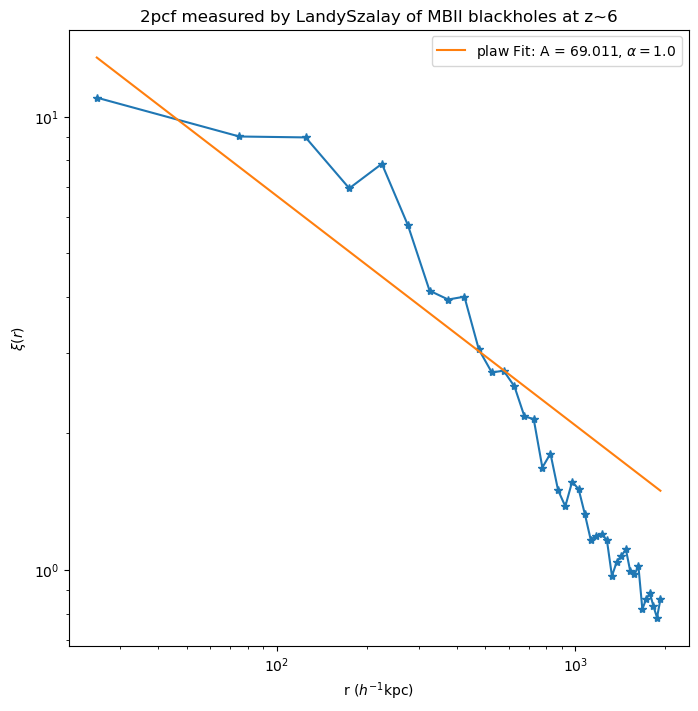

In [32]:
MBII_z6_filename = "bhprops_026.txt"
MBII_z6 = np.loadtxt(DATA_DIRECTORY + MBII_z6_filename)
redshift = 6

bh_pos_x = np.copy(MBII_z6[:, 2])
bh_pos_y = np.copy(MBII_z6[:, 3])
bh_pos_z = np.copy(MBII_z6[:, 4])
print(len(bh_pos_x)/50)

n_bins = 400
fig, ax = plt.subplots(figsize = (8,8))
hist_data = plt.hist(bh_pos_x, bins=n_bins, histtype='step')[0];
ax.set_xlabel(r'comoving x-position ($h^{-1}$kpc)')
ax.set_ylabel(r'Number of blackholes')
ax.text(0.70, 0.85, r'Bin size = {} $h^{{-1}}$kpc'.format(np.round((np.max(bh_pos_x) - np.min(bh_pos_x))/n_bins, 2)), transform = ax.transAxes)

fig2, ax2 = plt.subplots(figsize = (8,8))
hist_data = plt.hist(bh_pos_y, bins=n_bins, histtype='step')[0];
ax2.set_xlabel(r'comoving y-position ($h^{-1}$kpc)')
ax2.set_ylabel(r'Number of blackholes')
ax2.text(0.70, 0.85, r'Bin size = {} $h^{{-1}}$kpc'.format(np.round((np.max(bh_pos_y) - np.min(bh_pos_y))/n_bins, 2)), transform = ax2.transAxes)

fig3, ax3 = plt.subplots(figsize = (8,8))
hist_data = plt.hist(bh_pos_z, bins=n_bins, histtype='step')[0];
ax3.set_xlabel(r'comoving z-position ($h^{-1}$kpc)')
ax3.set_ylabel(r'Number of blackholes')
ax3.text(0.70, 0.85, r'Bin size = {} $h^{{-1}}$kpc'.format(np.round((np.max(bh_pos_z) - np.min(bh_pos_z))/n_bins, 2)), transform = ax3.transAxes)

mult = 10
n_D = len(bh_pos_x)
n_rand = mult * n_D
rand_x = np.random.uniform(np.min(bh_pos_x), np.max(bh_pos_x), n_rand)
rand_y = np.random.uniform(np.min(bh_pos_y), np.max(bh_pos_y), n_rand)

#-------------------------------------------------------------------------------------------
#Drawing random numbers for z from smoothed distribution of the data z vals
z_bin_size = 5

z_bin = np.arange(np.min(bh_pos_z), np.max(bh_pos_z), z_bin_size)[:,np.newaxis]
z_bin_mid = (z_bin + z_bin_size/2)[:-1]
kde = KernelDensity(kernel="gaussian", bandwidth=50).fit(bh_pos_z[:,np.newaxis])
log_dens = kde.score_samples(z_bin_mid)
pdf = np.exp(log_dens)
# ax.fill(pos_z[:, 0], pdf, fc="#AAAAFF")
cdf = np.cumsum(pdf)
cdf = cdf / np.max(cdf)
cdf = np.insert(cdf, 0, 0)

z_bin = z_bin.flatten()
z_bin_mid = z_bin_mid.flatten()

uni_val = np.random.rand(n_rand)
bin_indices = np.searchsorted(cdf, uni_val)
bin_edges = z_bin[bin_indices - 1]
bin_diff = z_bin[bin_indices] - z_bin[bin_indices-1]
bin_weights = (uni_val - cdf[bin_indices-1]) / (cdf[bin_indices] - cdf[bin_indices-1])
rand_z = bin_edges + bin_weights * bin_diff

#-------------------------------------------------------------------------------------------

bins = np.arange(0, 2000, 50)
bin_mids = (bins[0:-1] + bins[1:])/2

result_DD = DD(autocorr=1, nthreads=1, binfile=bins, X1 = bh_pos_x, Y1 = bh_pos_y, Z1 = bh_pos_z, periodic=False)
result_RR = DD(autocorr=1, nthreads=1, binfile=bins, X1 = rand_x, Y1 = rand_y, Z1 = rand_z, periodic=False)
result_DR = DD(autocorr=0, nthreads=1, binfile=bins, X1 = bh_pos_x, Y1 = bh_pos_y, Z1 = bh_pos_z, X2 = rand_x, Y2 = rand_y, Z2 = rand_z, periodic=False)

DD_norm = (n_D * (n_D - 1))/2
RR_norm = (n_rand * (n_rand - 1))/2
DR_norm = n_D * n_rand

DD_count = result_DD['npairs']/2
RR_count = result_RR['npairs']/2
DR_count = result_DR['npairs']

LandSzal2pcf = (DD_count/DD_norm - 2 * DR_count/DR_norm + RR_count/RR_norm)/(RR_count/RR_norm)

fig, ax = plt.subplots(figsize = (8,8))
ax.plot(bin_mids, LandSzal2pcf, '-*')
ax.set_xlabel(r'r ($h^{-1}$kpc)')
ax.set_ylabel(r'$\xi(r)$')
ax.set_title("2pcf measured by LandySzalay of MBII blackholes at z~{}".format(redshift))
ax.set_xscale('log')
ax.set_yscale('log')

temp_popt, temp_pcov = spo.curve_fit(pow_func, bin_mids, LandSzal2pcf)
_2pcf_fit_alpha = temp_popt[1]
_2pcf_fit_A = temp_popt[0]
ax.plot(bin_mids, pow_func(bin_mids, _2pcf_fit_A, _2pcf_fit_alpha), label=r"plaw Fit: A = {}, $\alpha = {}$".format(np.round(_2pcf_fit_A, 3), np.round(_2pcf_fit_alpha)))
ax.legend()

## Data at z ~ 7

24.44


/tmp/ipykernel_10026/1895688882.py:11: RuntimeWarning: overflow encountered in power
  return A * np.power(r, -alpha)


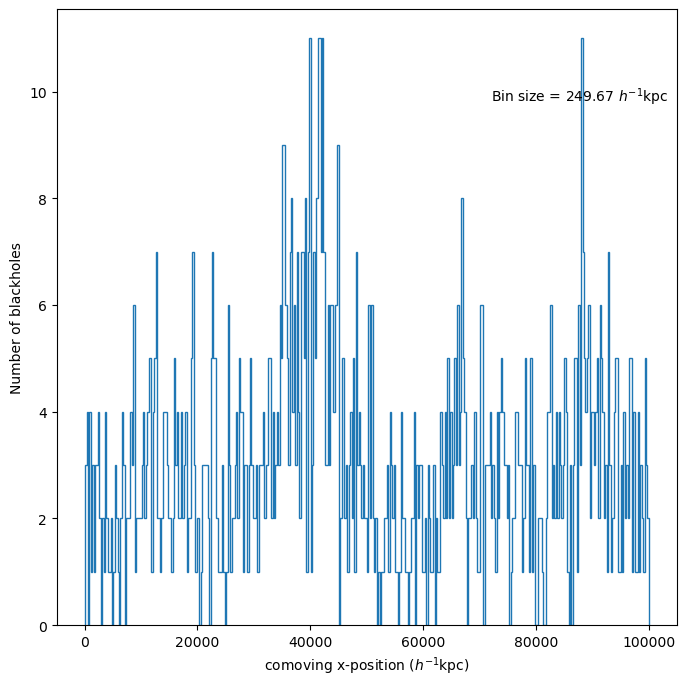

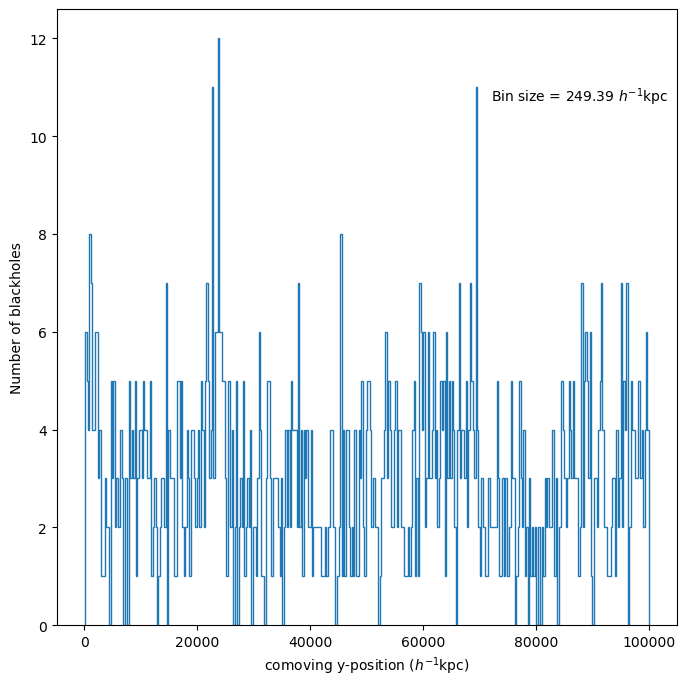

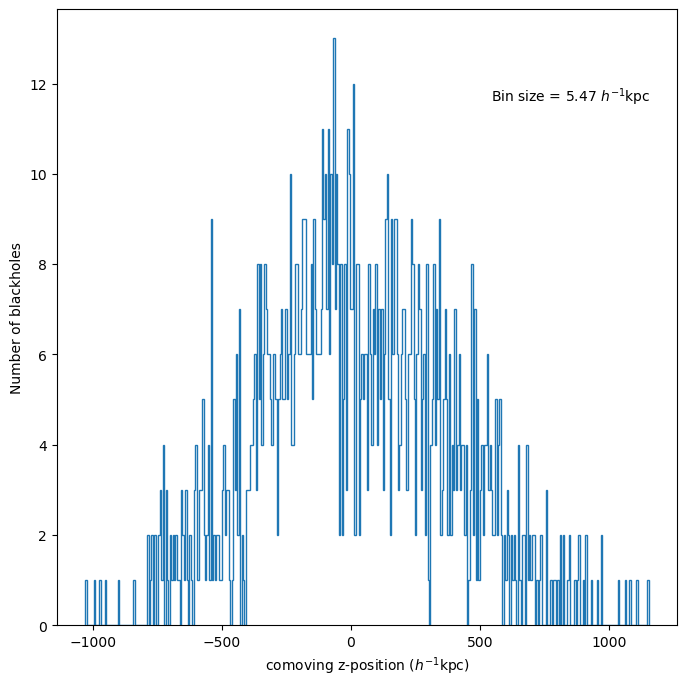

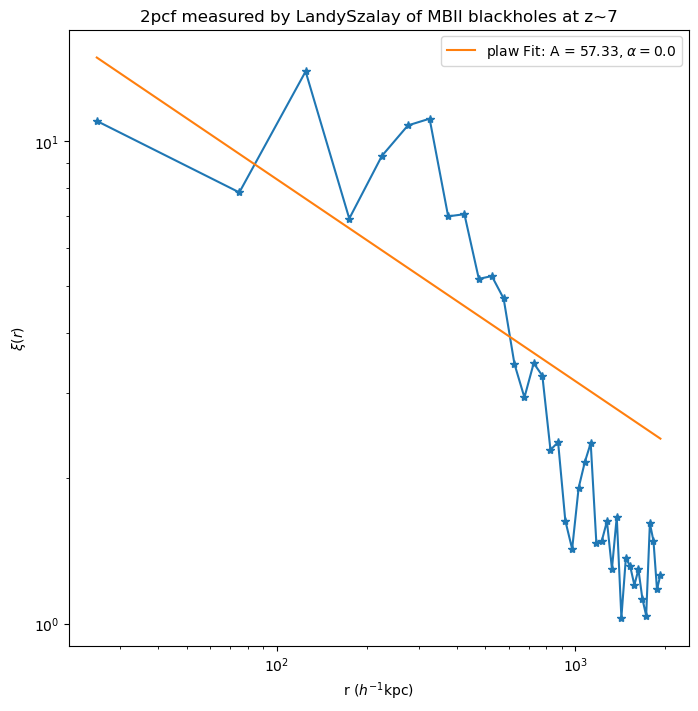

In [33]:
MBII_z6_filename = "bhprops_024.txt"
MBII_z6 = np.loadtxt(DATA_DIRECTORY + MBII_z6_filename)
redshift = 7

bh_pos_x = np.copy(MBII_z6[:, 2])
bh_pos_y = np.copy(MBII_z6[:, 3])
bh_pos_z = np.copy(MBII_z6[:, 4])
print(len(bh_pos_x)/50)

n_bins = 400
fig, ax = plt.subplots(figsize = (8,8))
hist_data = plt.hist(bh_pos_x, bins=n_bins, histtype='step')[0];
ax.set_xlabel(r'comoving x-position ($h^{-1}$kpc)')
ax.set_ylabel(r'Number of blackholes')
ax.text(0.70, 0.85, r'Bin size = {} $h^{{-1}}$kpc'.format(np.round((np.max(bh_pos_x) - np.min(bh_pos_x))/n_bins, 2)), transform = ax.transAxes)

fig2, ax2 = plt.subplots(figsize = (8,8))
hist_data = plt.hist(bh_pos_y, bins=n_bins, histtype='step')[0];
ax2.set_xlabel(r'comoving y-position ($h^{-1}$kpc)')
ax2.set_ylabel(r'Number of blackholes')
ax2.text(0.70, 0.85, r'Bin size = {} $h^{{-1}}$kpc'.format(np.round((np.max(bh_pos_y) - np.min(bh_pos_y))/n_bins, 2)), transform = ax2.transAxes)

fig3, ax3 = plt.subplots(figsize = (8,8))
hist_data = plt.hist(bh_pos_z, bins=n_bins, histtype='step')[0];
ax3.set_xlabel(r'comoving z-position ($h^{-1}$kpc)')
ax3.set_ylabel(r'Number of blackholes')
ax3.text(0.70, 0.85, r'Bin size = {} $h^{{-1}}$kpc'.format(np.round((np.max(bh_pos_z) - np.min(bh_pos_z))/n_bins, 2)), transform = ax3.transAxes)

mult = 10
n_D = len(bh_pos_x)
n_rand = mult * n_D
rand_x = np.random.uniform(np.min(bh_pos_x), np.max(bh_pos_x), n_rand)
rand_y = np.random.uniform(np.min(bh_pos_y), np.max(bh_pos_y), n_rand)

#-------------------------------------------------------------------------------------------
#Drawing random numbers for z from smoothed distribution of the data z vals
z_bin_size = 5

z_bin = np.arange(np.min(bh_pos_z), np.max(bh_pos_z), z_bin_size)[:,np.newaxis]
z_bin_mid = (z_bin + z_bin_size/2)[:-1]
kde = KernelDensity(kernel="gaussian", bandwidth=50).fit(bh_pos_z[:,np.newaxis])
log_dens = kde.score_samples(z_bin_mid)
pdf = np.exp(log_dens)
# ax.fill(pos_z[:, 0], pdf, fc="#AAAAFF")
cdf = np.cumsum(pdf)
cdf = cdf / np.max(cdf)
cdf = np.insert(cdf, 0, 0)

z_bin = z_bin.flatten()
z_bin_mid = z_bin_mid.flatten()

uni_val = np.random.rand(n_rand)
bin_indices = np.searchsorted(cdf, uni_val)
bin_edges = z_bin[bin_indices - 1]
bin_diff = z_bin[bin_indices] - z_bin[bin_indices-1]
bin_weights = (uni_val - cdf[bin_indices-1]) / (cdf[bin_indices] - cdf[bin_indices-1])
rand_z = bin_edges + bin_weights * bin_diff

#-------------------------------------------------------------------------------------------

bins = np.arange(0, 2000, 50)
bin_mids = (bins[0:-1] + bins[1:])/2

result_DD = DD(autocorr=1, nthreads=1, binfile=bins, X1 = bh_pos_x, Y1 = bh_pos_y, Z1 = bh_pos_z, periodic=False)
result_RR = DD(autocorr=1, nthreads=1, binfile=bins, X1 = rand_x, Y1 = rand_y, Z1 = rand_z, periodic=False)
result_DR = DD(autocorr=0, nthreads=1, binfile=bins, X1 = bh_pos_x, Y1 = bh_pos_y, Z1 = bh_pos_z, X2 = rand_x, Y2 = rand_y, Z2 = rand_z, periodic=False)

DD_norm = (n_D * (n_D - 1))/2
RR_norm = (n_rand * (n_rand - 1))/2
DR_norm = n_D * n_rand

DD_count = result_DD['npairs']/2
RR_count = result_RR['npairs']/2
DR_count = result_DR['npairs']

LandSzal2pcf = (DD_count/DD_norm - 2 * DR_count/DR_norm + RR_count/RR_norm)/(RR_count/RR_norm)

fig, ax = plt.subplots(figsize = (8,8))
ax.plot(bin_mids, LandSzal2pcf, '-*')
ax.set_xlabel(r'r ($h^{-1}$kpc)')
ax.set_ylabel(r'$\xi(r)$')
ax.set_title("2pcf measured by LandySzalay of MBII blackholes at z~{}".format(redshift))
ax.set_xscale('log')
ax.set_yscale('log')

temp_popt, temp_pcov = spo.curve_fit(pow_func, bin_mids, LandSzal2pcf)
_2pcf_fit_alpha = temp_popt[1]
_2pcf_fit_A = temp_popt[0]
ax.plot(bin_mids, pow_func(bin_mids, _2pcf_fit_A, _2pcf_fit_alpha), label=r"plaw Fit: A = {}, $\alpha = {}$".format(np.round(_2pcf_fit_A, 3), np.round(_2pcf_fit_alpha)))
ax.legend()